# Intuit Quickbooks Upgrade

* Team-lead GitHub userid: rsm-xyz123
* Group name:
* Team member names:
    - Aarushi Gaikwad
    - Charles Qian
    - Kieran Huffman
    - Sakshi Gandhi

## Setup

Please complete this python notebook with your group by answering the questions in `intuit_quickbooks-msba.pdf`. Create a Notebook with all your results and comments and push both the Notebook to GitHub when your team is done. Before the deadline, make sure to connect the GitHub repo to GradeScope. All results MUST be reproducible (i.e., the TA and I must be able to recreate your output from the Jupyter Notebook without changes or errors). This means that you should NOT use any python-packages that are not part of the RSM-MSBA docker container.

> Note: Please do not install any packages as part of your Jupyter Notebook submission

This is the first group assignment for MGTA 455 and you will be using Git and GitHub. If two people edit the same file at the same time you could get what is called a "merge conflict". This is not something serious but you should realize that Git will not decide for you who's changes to accept. The team-lead will have to determine the edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitHub. Make "pull first" a habit!

If multiple people are going to work on the assignment at the same time I recommend you work in different notebooks. You can then `%run ...`  these "sub" notebooks from the main assignment file. You can seen an example of this in action below for the `question1.ipynb` notebook

Some group work-flow tips:

* Pull, edit, save, stage, commit, and push
* Schedule who does what and when
* Try to avoid working simultaneously on the same file
* If you are going to work simultaneously, do it in different notebooks, e.g.,
    - question1.ipynb, question2.ipynb, question3.ipynb
* Use the `%run ... ` command to bring different pieces of code together into the main jupyter notebook
* Put python functions in modules that you can import from your notebooks. See the example below for the `example` function defined in `utils/functions.py`

A graphical depiction of the group work-flow is shown below:

![](images/github-group-workflow.png) 

In this step, we import all necessary libraries for data analysis, visualization, 
and machine learning. `pyrsm` is used for model evaluation, `statsmodels` for regression, 
`sklearn` for preprocessing, and `matplotlib` for visualization. 
We also set a higher DPI for clearer plots.

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

# increase plot resolution
mpl.rcParams["figure.dpi"] = 150

Since `pyrsm` is required for model evaluation, we check if it's installed.
If not, we install it using `%pip install`, which ensures the package is installed 
in the correct Jupyter environment.

In [8]:
%pip install --upgrade pyrsm

Note: you may need to restart the kernel to use updated packages.


### First, we need to load the data, and check the structure of the data

We load the dataset from a `.parquet` file, which contains customer details. We create a binary column (`res1_yes`) that indicates whether a customer responded to the first mailing wave. We also print basic dataset statistics.

In [9]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_parquet("data/intuit75k.parquet")
intuit75k["res1_yes"] = rsm.ifelse(intuit75k.res1 == "Yes", 1, 0)

rsm.describe(intuit75k)

intuit75k.head()

No description attribute available


,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


To prepare the dataset for modeling, we apply **standardization** and **one-hot encoding**:

1. **Standardization**: Ensures that numerical features (`numords`, `dollars`, `last`, `sincepurch`) have a uniform scale. This prevents large values from dominating smaller ones in distance-based models.
2. **One-Hot Encoding**: Converts the categorical `sex` variable into three separate binary (0/1) columns:  
   - `sex_male`: 1 if Male, else 0  
   - `sex_female`: 1 if Female, else 0  
   - `sex_unknown`: 1 if Unknown, else 0  

These transformations make the dataset compatible with machine learning algorithms.

In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Select numeric columns to standardize
num_cols = ["numords", "dollars", "last", "sincepurch"]
intuit75k[num_cols] = scaler.fit_transform(intuit75k[num_cols])

# One-hot encoding for the categorical "sex" variable
intuit75k["sex_male"] = np.where(intuit75k["sex"] == "Male", 1, 0)
intuit75k["sex_female"] = np.where(intuit75k["sex"] == "Female", 1, 0)
intuit75k["sex_unknown"] = np.where(intuit75k["sex"] == "Unknown", 1, 0)

To evaluate our model’s performance fairly, we split the dataset into:
- **Training Set (`train_set`)**: Used to train the model.
- **Test Set (`test_set`)**: Used for evaluation on unseen data.

This separation ensures that the model learns from one subset while being tested on another, helping us assess its generalization ability before deployment.

In [11]:
# split the data
test_set = intuit75k[intuit75k.training == 0]
train_set = intuit75k[intuit75k.training == 1]

### **Feature Selection Using Lasso Regression**

In this step, we use **LassoCV (Lasso with Cross-Validation)** to select the most important features for predicting customer response.

1. **Dropping Unnecessary Columns**:  
   - `id` and `zip5` are removed because they are unique identifiers, not predictive features.
   - `sex` is removed since we already encoded it into three separate columns.
   - `res1` and `res1_yes` are removed because they are the target variables.
   
2. **Feature Scaling**:  
   - We apply `StandardScaler` to normalize the numeric features before Lasso regression.

3. **LassoCV**:  
   - Performs **automatic feature selection** by penalizing less important coefficients.
   - Uses 10-fold cross-validation (`cv=10`) to select the best regularization strength (`alpha`).
   - Outputs:
     - The **number of selected features**.
     - The **indices of features with non-zero weights**.
     - The **optimal alpha value** (strength of regularization).


In [12]:
## Lasso slection of variables
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import numpy as np

## We think that ID, sex,  and zip5 are not useful for the model
## because they are just identifiers, and we tansformed sex into three columns already.
X = intuit75k.drop(columns=["res1", "res1_yes", "training", 'id','zip5','sex'])
y = intuit75k.res1_yes

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = LassoCV(cv=10).fit(X_scaled, y)

# number of features used
print("number of features used:", np.sum(lasso.coef_ != 0))
# features with non-zero weight
print("features with non-zero weight:", np.where(lasso.coef_ != 0)[0])
# bets alpha
print("best alpha:", lasso.alpha_)

number of features used: 11
features with non-zero weight: [ 0  1  2  3  4  5  6  7  8  9 10]
best alpha: 0.000122671736618793


### **Extracting Features Selected by Lasso**

After running **Lasso Regression**, we extract the most important features based on the non-zero coefficients.

1. We retrieve the names of the features selected by Lasso.
2. These features will be used as inputs for the machine learning model.

In [13]:
feature_names = X.columns  # Define feature_names from DataFrame columns
index_lasso = np.where(lasso.coef_ != 0)[0]  # Get indices dynamically
lasso_features = feature_names[index_lasso]
print("Lasso-selected Features:", list(lasso_features))

Lasso-selected Features: ['zip_bins', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch', 'version1', 'owntaxprod', 'upgraded', 'sex_male', 'sex_female']


# Building the First Neural Network Model (clf1)
### Defining Selected Variables for Model Training
**We progressed to constructing our first neural network model**
Based on Lasso regression results, we manually define the **independent variables (`evar`)** for the classification model.

These selected features include:
- **Demographics**: `zip_bins`, `bizflag`
- **Transaction History**: `numords`, `dollars`, `last`, `sincepurch`
- **Product Details**: `version1`, `owntaxprod`, `upgraded`
- **Categorical Variable (`sex`)**: Should be replaced with its one-hot encoded versions (`sex_male`, `sex_female`, `sex_unknown`) instead of `sex`.

In [14]:
evar=[
    'zip_bins', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch',
       'version1', 'owntaxprod', 'upgraded', 'sex'
]


### Training Neural Network Model (MLP)

We train a **Multilayer Perceptron (MLP)** model to predict whether a customer will respond to the second wave of mailing.

**Key Parameters:**
- **Training Data**: Uses customers where `training == 1` (from `intuit75k`).
- **Target Variable (`rvar`)**: `res1`, indicating response (`Yes` or `No`).
- **Feature Variables (`evar`)**: Uses the selected features.
- **Hidden Layers**: A single hidden layer (`hidden_layer_sizes=(1,)`).
- **Model Type**: Classification task.

In [15]:
clf1 = rsm.model.mlp(
    data={"fpb_train": intuit75k[intuit75k.training == 1]},
    rvar="res1",
    lev="Yes",
    evar=evar,
    hidden_layer_sizes=(1,),
    mod_type="classification",
)
clf1.summary()

Multi-layer Perceptron (NN)
Data                 : fpb_train
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded, sex
Model type           : classification
Nr. of features      : (10, 11)
Nr. of weights       : 12
Nr. of observations  : 52,500
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.709

Raw data             :
 zip_bins  bizflag   numords   dollars      last  sincepurch  version1  owntaxprod  upgraded  sex
       18        0 -0.061449  0.202116 -1.136223   -0.364760         0           0         0 Male
        1        0 -0.867026 -0.875400  0.121771   -1.461881         0           0         0 Male
        3        0 -0.867026 -0.900028  0.121771    0.133931      

### Plotting Feature Importance

We visualize the **importance of selected features** in the trained model.

This helps understand which factors influence customer response the most.

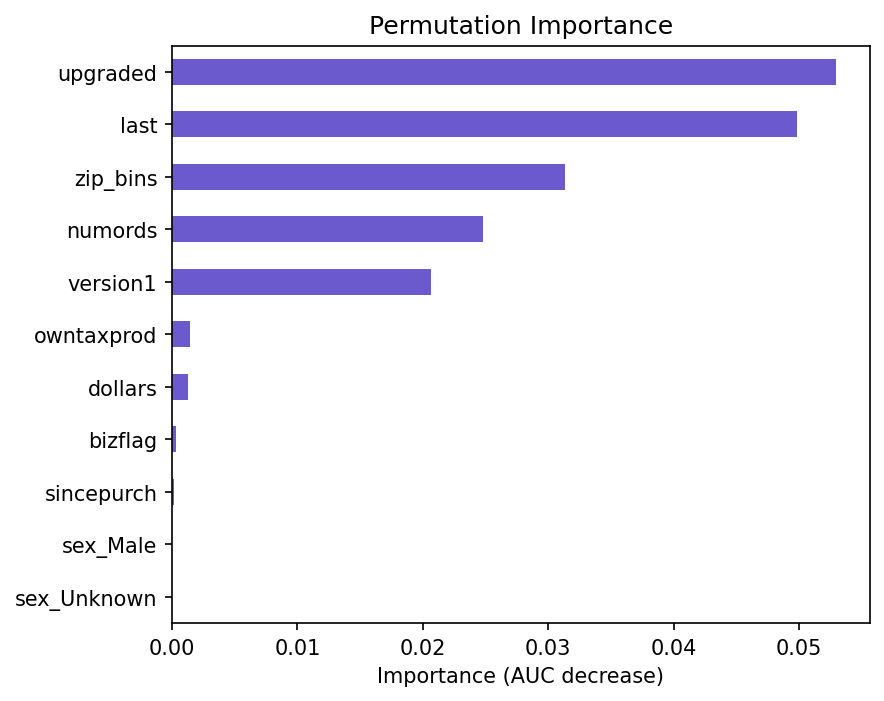

In [16]:
clf1.plot('vimp_sklearn')

### Hyperparameter Tuning with Grid Search

To improve the performance of our **Neural Network (MLP) model**, we use **GridSearchCV** to find the optimal architecture.

1. **Hyperparameter Choices (`hls`)**:  
   - Defines different configurations for the hidden layers (e.g., `(20,20)`, `(5,)`, etc.).
   - These different architectures will be tested to find the best one.

2. **GridSearchCV Setup**:  
   - **Parameter Grid (`param_grid`)**: We test different `hidden_layer_sizes` to find the best one.
   - **Scoring Metric (`AUC`)**: We use the **ROC AUC** score to evaluate the model.
   - **Cross-validation (`cv=5`)**: Splits the training data into 5 folds for better model evaluation.
   - **Parallel Processing (`n_jobs=4`)**: Uses multiple CPU cores to speed up tuning.

3. **Fitting the Model**:  
   - We fit `clf_cv` (grid search) using the one-hot encoded dataset.
   - This process selects the best hidden layer configuration for our neural network.

In [17]:
from sklearn.model_selection import GridSearchCV

hls = [(20,20),(5,3),(4,2),(4,2,2),(5,),(2,2,4,3)]

param_grid = {'hidden_layer_sizes': hls}
scoring = {'AUC': 'roc_auc'}

clf_cv = GridSearchCV(
    clf1.fitted, param_grid, scoring=scoring, cv=5, n_jobs = 4, refit = 'AUC', verbose = 5
)

clf1.data_onehot.mean().round(3)
clf_cv.fit(clf1.data_onehot, clf1.data.res1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='tanh', hidden_layer_sizes=(1,),
                                     max_iter=1000000, random_state=1234,
                                     solver='lbfgs'),
             n_jobs=4,
             param_grid={'hidden_layer_sizes': [(20, 20), (5, 3), (4, 2),
                                                (4, 2, 2), (5,),
                                                (2, 2, 4, 3)]},
             refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)

### Viewing Grid Search Results

After running **GridSearchCV**, we analyze the results:

1. **Preview One-Hot Encoded Data**:  
   - `clf1.data_onehot.head()` shows the transformed dataset that was used for training.

2. **Grid Search Performance Analysis**:  
   - Converts `clf_cv.cv_results_` to a DataFrame for easy inspection.
   - Sorts the results by `rank_test_AUC` to find the best-performing architecture.

This helps us determine which **hidden layer size** performed best in predicting customer responses.

In [18]:
clf1.data_onehot.head()
pd.DataFrame(clf_cv.cv_results_).iloc[:, 5:].sort_values("rank_test_AUC")

,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
1,"{'hidden_layer_sizes': (5, 3)}",0.742270,0.761939,0.770003,0.751036,0.766001,0.758250,0.010191,1
4,"{'hidden_layer_sizes': (5,)}",0.744455,0.760851,0.765171,0.754120,0.766230,0.758165,0.008070,2
2,"{'hidden_layer_sizes': (4, 2)}",0.740850,0.760526,0.765998,0.752036,0.766898,0.757262,0.009762,3
3,"{'hidden_layer_sizes': (4, 2, 2)}",0.744610,0.759922,0.768903,0.737857,0.761700,0.754598,0.011519,4
5,"{'hidden_layer_sizes': (2, 2, 4, 3)}",0.735472,0.750810,0.760654,0.748661,0.761839,0.751487,0.009551,5
0,"{'hidden_layer_sizes': (20, 20)}",0.654188,0.637119,0.645752,0.645485,0.636373,0.643783,0.006548,6


## Building the second Neural Network Model (clf2):
### Retraining MLP Model with Best Parameters

After identifying `(5,)` as the best hidden layer configuration, we **retrain the neural network** using this optimized setup.

1. **Training Data**: Uses the `fpb_train` subset where `training == 1`.
2. **Target Variable (`rvar`)**: Predicts `res1` (customer response).
3. **Feature Variables (`evar`)**: Uses the best-selected features.
4. **Hidden Layer Configuration**: `(5,)` (single layer with 5 neurons).
5. **Model Type**: Classification task.

This model is expected to **perform better** than the initial MLP model (`clf1`).



In [19]:
## (5,) is the best, so we retrain the model with this configuration
clf2 = rsm.model.mlp(
    data={"fpb_train": intuit75k[intuit75k.training == 1]},
    rvar="res1",
    lev="Yes",
    evar=evar,
    hidden_layer_sizes=(5,),
    mod_type="classification",
)
clf2.summary()

Multi-layer Perceptron (NN)
Data                 : fpb_train
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded, sex
Model type           : classification
Nr. of features      : (10, 11)
Nr. of weights       : 60
Nr. of observations  : 52,500
Hidden_layer_sizes   : (5,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.764

Raw data             :
 zip_bins  bizflag   numords   dollars      last  sincepurch  version1  owntaxprod  upgraded  sex
       18        0 -0.061449  0.202116 -1.136223   -0.364760         0           0         0 Male
        1        0 -0.867026 -0.875400  0.121771   -1.461881         0           0         0 Male
        3        0 -0.867026 -0.900028  0.121771    0.133931      

### Comparing Feature Importance

We visualize and compare **feature importance** for both trained MLP models (`clf1` and `clf2`).

- **Why?** Helps understand which factors most influence the model’s predictions.
- **If `clf1.plot('vimp')` Fails:** Use `matplotlib` to manually plot feature importance.

This allows us to validate if **the second model (`clf2`) improved** feature interpretation compared to `clf1`.

(None, None)

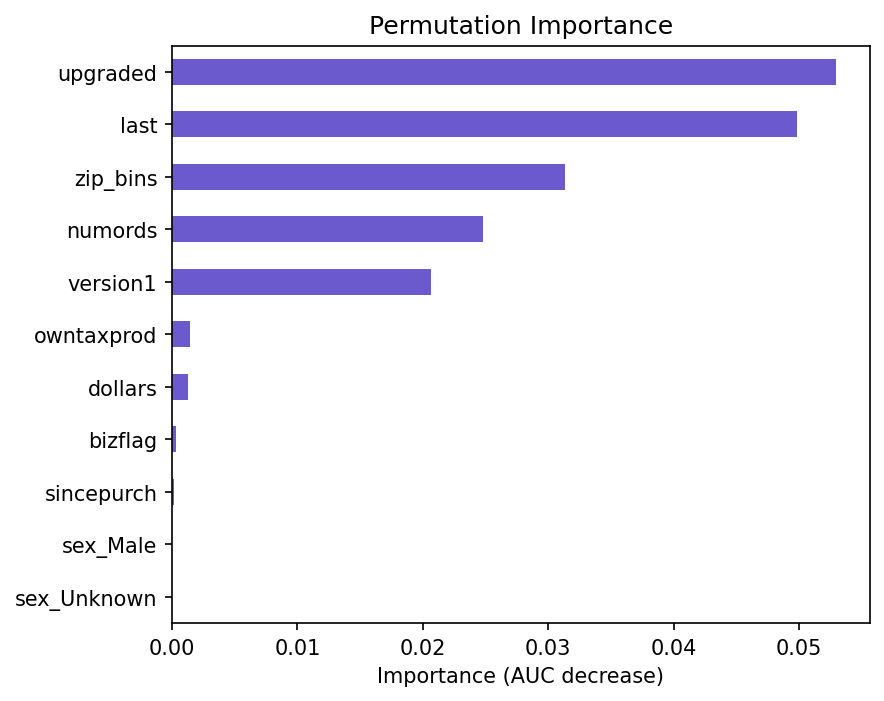

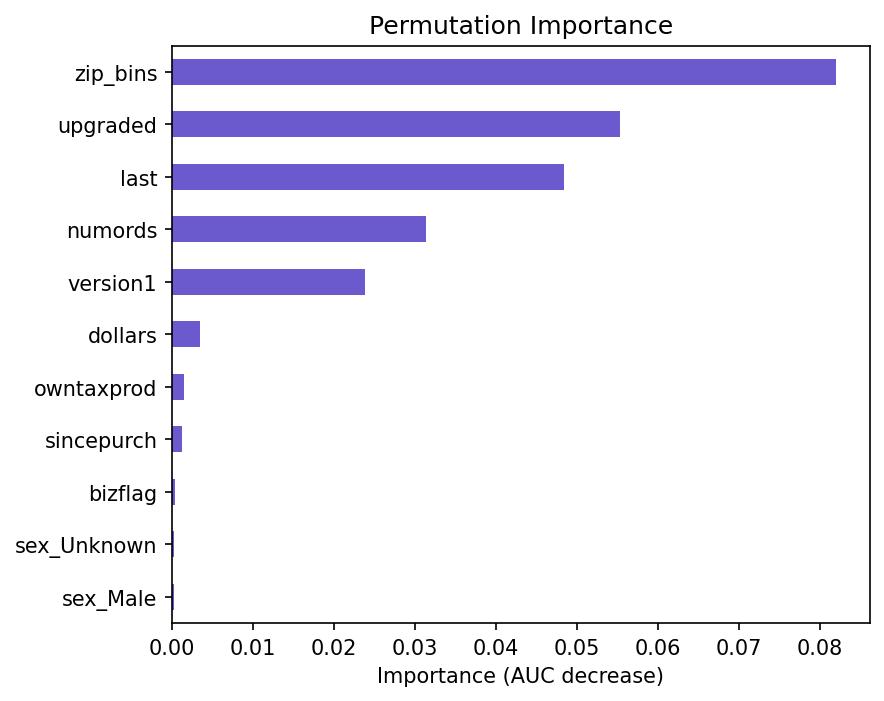

In [20]:
clf1.plot('vimp_sklearn'), clf2.plot('vimp_sklearn')

#### Generating Predictions with Neural Networks

We generate predictions from both trained MLP models:
- **`pred_nn1`**: Predictions from the first model (`clf1`).
- **`pred_nn2`**: Predictions from the optimized model (`clf2`).

These predictions will be used in further analysis to compare accuracy and profitability of both models.

In [21]:
intuit75k['pred_nn1'] = clf1.predict(intuit75k)['prediction']
intuit75k['pred_nn2'] = clf2.predict(intuit75k)['prediction']

### Gain Chart for Model `clf1` (Train vs Test)

We generate a **Gain Chart (ROC Curve)** to evaluate the predictive ranking ability of the model **separately for training and test data**.

- **Why Two Curves?**  
  - The **blue dashed curve** represents the model's performance on the **training set**.
  - The **red solid curve** represents the model's performance on the **test set**.
  - If the test curve is much lower than the training curve, the model may be **overfitting**.

- **How It Works:**  
  - Computes **ROC Curves** for both `y_train` and `y_test` using `roc_curve()`.
  - Plots both curves to visually compare model performance on different datasets.

**Expected Outcome:**  
- The **test curve should closely follow the train curve**.
- A significant gap means the model might be **overfitting**, requiring more tuning.

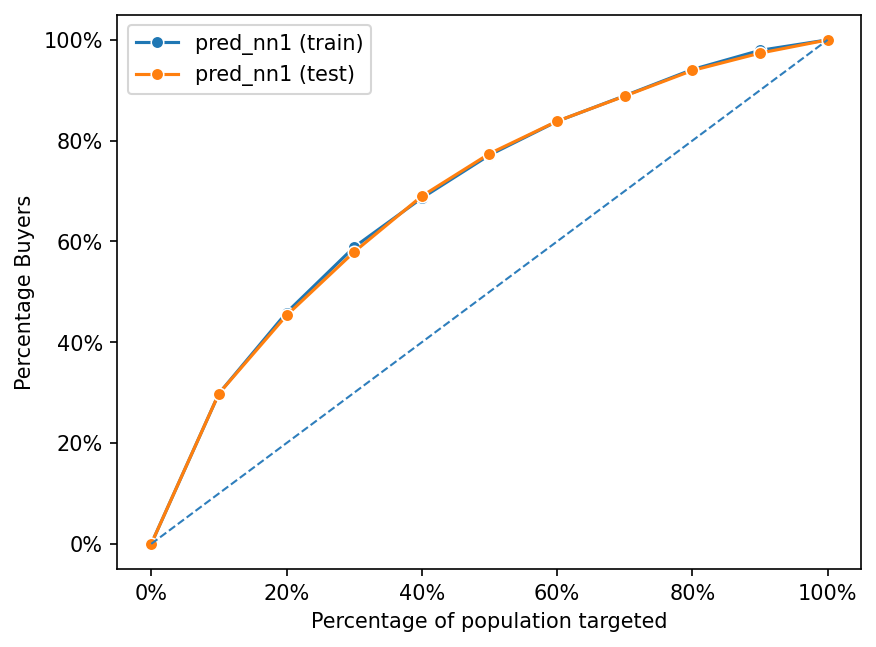

In [22]:
## gain chart of model clf1
dct = {"train": intuit75k[intuit75k['training'] == 1], "test": intuit75k[intuit75k['training'] == 0]}
fig1 = rsm.gains_plot(dct, "res1", "Yes", "pred_nn1")

### Gain Chart for Model `clf2`

A **Gain Chart** is used to assess the effectiveness of model `clf2` in predicting customer responses.

- **Purpose:**  
  - Helps visualize how well `clf2` ranks customers who are likely to respond.
  - Compares model performance with `clf1` to determine if hyperparameter tuning improved predictive accuracy.

- **Implementation:**  
  - `rsm.gains_plot()` generates the Gain Chart using predictions from `clf2` (`pred_nn2`).

**Expected Outcome:**  
- A steeper curve indicates a **better ability** to rank potential responders.
- Comparing `clf2` with `clf1` should reveal if the tuning resulted in a **better model**.

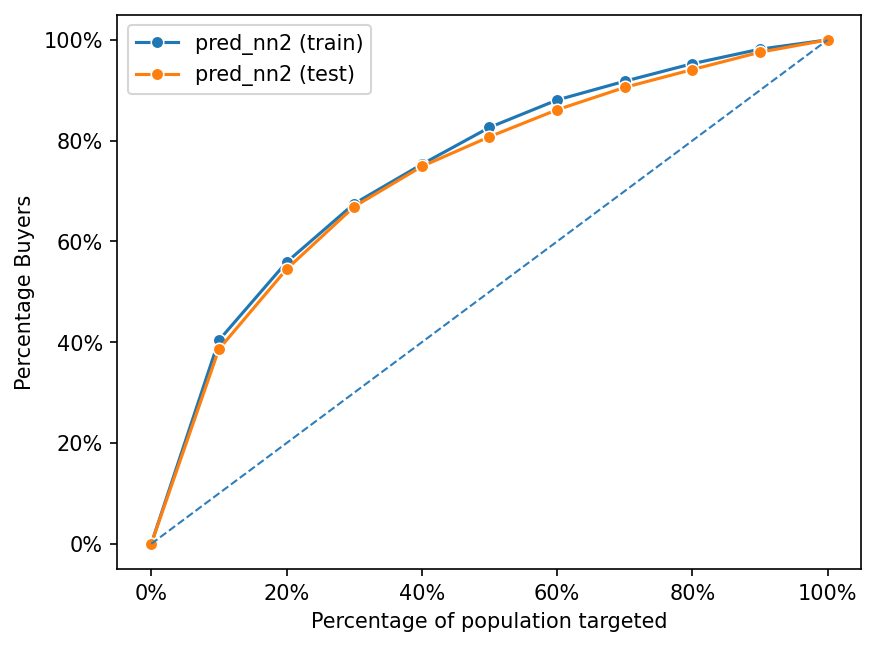

In [23]:
## gain chart of model clf2
fig2 = rsm.gains_plot(dct, "res1", "Yes", "pred_nn2")

## 4: Building the third Neural Network Model (clf3):

### Selecting a Reduced Feature Set for a New Model

We refine our **feature selection** by choosing only the most impactful variables from the previous feature importance analysis.

- **Why Reduce Features?**  
  - Simplifies the model, reducing overfitting.
  - Improves interpretability and computational efficiency.

- **Selected Features:**  
  - `upgraded`, `last`, `zip_bins`, `numords`, `version1`
  - These features showed **high importance** in previous models.

This refined feature set will be used to train a **new neural network (`clf3`)**.


In [24]:
## new model
evar2=[
    "upgraded",
    "last",
    "zip_bins",
    "numords",
    "version1",
]

### Training a New Neural Network Model (`clf3`)

We train a **third neural network (`clf3`)** using a **reduced feature set**.

#### **Why Train a New Model?**
- The previous models (`clf1` and `clf2`) included all available features.
- Based on feature importance analysis, we reduce the number of features to improve efficiency and generalization.
- This helps to avoid overfitting and ensures that only the most relevant features are used.

#### **Key Model Parameters:**
- **Dataset**: Uses only training data (`training == 1`).
- **Target Variable (`rvar`)**: `res1`, indicating customer response.
- **Feature Variables (`evar2`)**: Includes only the most relevant predictors.
- **Hidden Layers**: `(1,)`, meaning a single-layer neural network.
- **Model Type**: Classification.

#### **Expected Outcome:**
- `clf3` should be **simpler yet effective**, reducing unnecessary complexity.
- The **feature importance plot (`plot('vimp')`)** should highlight the strongest predictors.

Multi-layer Perceptron (NN)
Data                 : fpb_train
Response variable    : res1
Level                : Yes
Explanatory variables: upgraded, last, zip_bins, numords, version1
Model type           : classification
Nr. of features      : (5, 5)
Nr. of weights       : 6
Nr. of observations  : 52,500
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.707

Raw data             :
 upgraded      last  zip_bins   numords  version1
        0 -1.136223        18 -0.061449         0
        0  0.121771         1 -0.867026         0
        1  0.121771         3 -0.867026         0
        0 -1.241056        11 -0.867026         1
        0 -0.612059         5  0.744127         0

Estimation data      :
 upgraded      last  zip_bins   numords  version1
        0 -1.137183  1.301549 -0.057

(None, None)

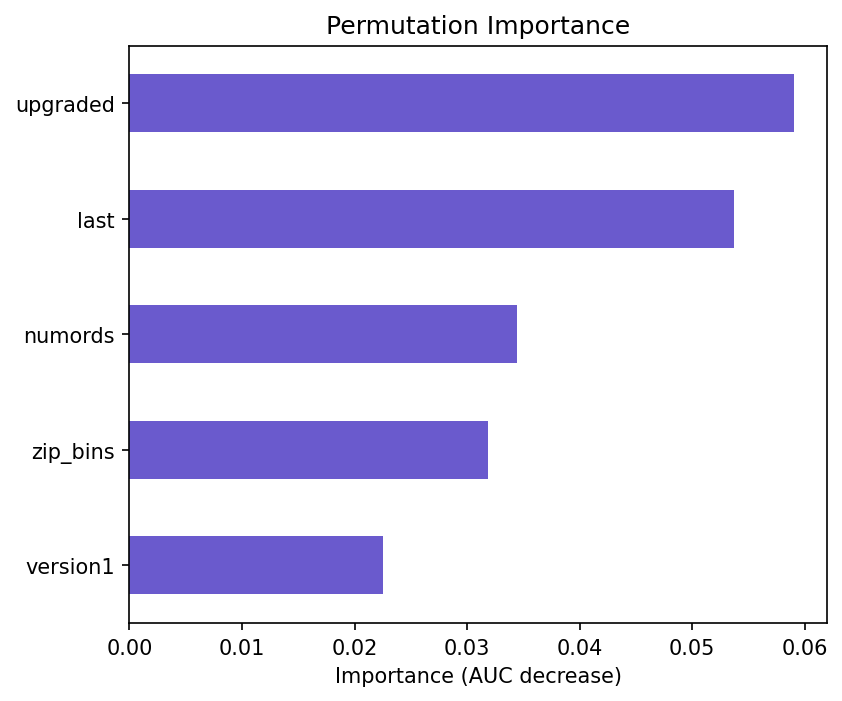

In [25]:
clf3 = rsm.model.mlp(
    data={"fpb_train": intuit75k[intuit75k.training == 1]},
    rvar="res1",
    lev="Yes",
    evar=evar2,
    hidden_layer_sizes=(1,),
    mod_type="classification",
)
clf3.summary(), clf3.plot('vimp')

### Hyperparameter Tuning for `clf3`

To improve model performance, we use **GridSearchCV** to find the best hidden layer architecture.

#### **Why Perform Hyperparameter Tuning?**
- The choice of **hidden layer size** impacts the model’s ability to learn complex relationships.
- A well-optimized architecture can significantly **improve predictive performance**.

#### **Key Tuning Parameters:**
- **Hidden Layer Configurations (`hls`)**:  
  - Various structures tested (e.g., `(20,20)`, `(5,)`, `(4,2,2)`, etc.).
- **Evaluation Metric (`AUC`)**:  
  - We aim to maximize the **Area Under the ROC Curve**.
- **Cross-Validation (`cv=5`)**:  
  - The dataset is split into 5 folds to ensure robust evaluation.
- **Parallel Processing (`n_jobs=4`)**:  
  - Runs tuning in parallel for efficiency.

#### **Expected Outcome:**
- The best **hidden layer size** will be selected.
- The highest **AUC score** will indicate model improvement.


In [26]:
hls = [(20,20),(5,),(4,2),(4,2,2),(5,2),(2,2,4,3)]

param_grid = {'hidden_layer_sizes': hls}
scoring = {'AUC': 'roc_auc'}

clf_cv = GridSearchCV(
    clf3.fitted, param_grid, scoring=scoring, cv=5, n_jobs = 4, refit = 'AUC', verbose = 5
)

clf3.data_onehot.mean().round(3)
clf_cv.fit(clf3.data_onehot, clf3.data.res1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='tanh', hidden_layer_sizes=(1,),
                                     max_iter=1000000, random_state=1234,
                                     solver='lbfgs'),
             n_jobs=4,
             param_grid={'hidden_layer_sizes': [(20, 20), (5,), (4, 2),
                                                (4, 2, 2), (5, 2),
                                                (2, 2, 4, 3)]},
             refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)

### Viewing Grid Search Results

After running **GridSearchCV**, we analyze the results to identify the best-performing configuration.

#### **What We Do Here:**
1. **Check the Preprocessed Data (`data_onehot.head()`)**  
   - Ensures that the dataset used for training is correctly formatted.
  
2. **Analyze Hyperparameter Tuning Results (`clf_cv.cv_results_`)**  
   - Converts the GridSearch results into a DataFrame.
   - Sorts results by `rank_test_AUC`, displaying the **top-performing configurations** first.

#### **Expected Outcome:**
- We should see a list of hyperparameter configurations ranked by their **AUC performance**.
- The **best model** should have the highest AUC.


In [27]:
clf3.data_onehot.head()
pd.DataFrame(clf_cv.cv_results_).iloc[:, 5:].sort_values("rank_test_AUC")

,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
4,"{'hidden_layer_sizes': (5, 2)}",0.740777,0.765212,0.769161,0.752060,0.767041,0.758850,0.010832,1
1,"{'hidden_layer_sizes': (5,)}",0.741148,0.764175,0.767626,0.753386,0.765430,0.758353,0.009906,2
3,"{'hidden_layer_sizes': (4, 2, 2)}",0.741816,0.762618,0.768119,0.750539,0.764692,0.757557,0.009850,3
2,"{'hidden_layer_sizes': (4, 2)}",0.741867,0.760843,0.768030,0.751228,0.765020,0.757398,0.009615,4
5,"{'hidden_layer_sizes': (2, 2, 4, 3)}",0.730310,0.756727,0.751908,0.710718,0.756263,0.741185,0.018058,5
0,"{'hidden_layer_sizes': (20, 20)}",0.691348,0.707042,0.721563,0.688800,0.708272,0.703405,0.012044,6


### Extracting Best Model Parameters

We retrieve the **best hyperparameters and AUC score** identified by GridSearchCV.

#### **What This Does:**
- `clf_cv.best_params_`: Shows the best-performing **hidden layer size**.
- `clf_cv.best_score_`: Displays the **highest AUC score** achieved.

#### **Expected Outcome:**
- The optimal `hidden_layer_sizes` configuration should be printed.
- The **highest AUC score** should confirm model improvement.

In [28]:
clf_cv.best_params_, clf_cv.best_score_.round(3)

({'hidden_layer_sizes': (5, 2)}, 0.759)

### Visualizing Model Predictions

We generate a **prediction plot** to examine how the model’s response varies across different features.

#### **Why This Is Important:**
- Helps **visualize the effect of interactions** between variables.
- Highlights **how predicted probabilities change** based on feature values.

#### **Key Parameters:**
- `"pred"`: Generates a **prediction plot**.
- `incl=[]`: No additional variables included.
- `incl_int`: Specifies **interaction terms** (`last:version1`, `numords:version1`).

#### **Expected Outcome:**
- The plot should reveal how feature interactions influence response probability.
- If no patterns emerge, it may indicate that **these interactions are not meaningful**.


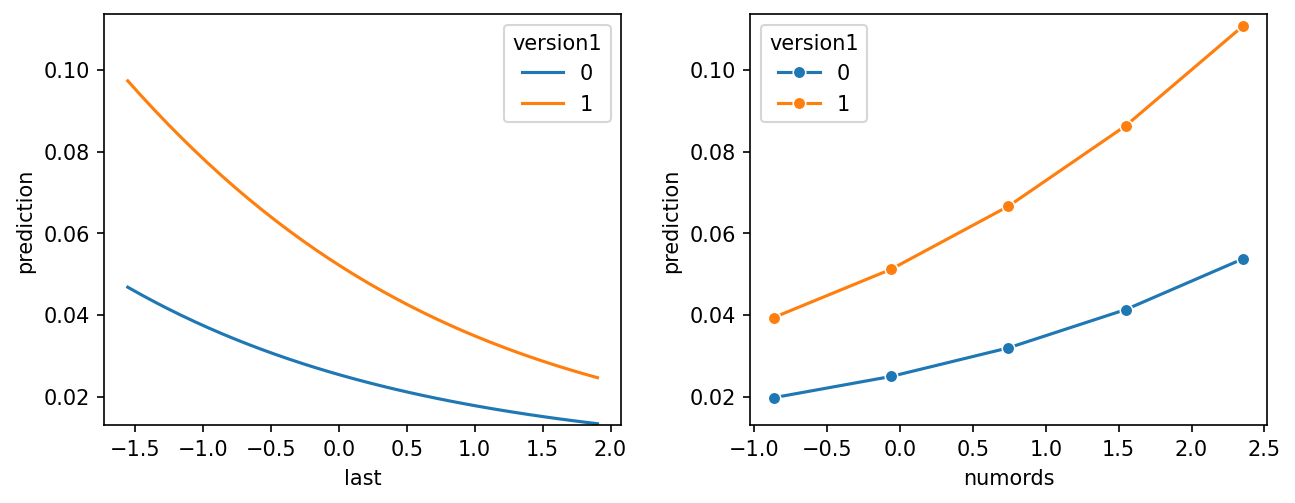

In [29]:
clf3.plot("pred", incl=[], incl_int = ["last:version1", "numords:version1"])

# Training the Final Neural Network Model (`clf4`)

We train a **fourth neural network (`clf4`)** using the best parameters found in hyperparameter tuning.

#### **Why Train Another Model?**
- Now that we have **optimized hyperparameters**, we retrain a model using them.
- This should yield **better predictive accuracy** than previous models (`clf1`, `clf2`, `clf3`).

#### **Key Differences from Previous Models:**
- Uses the **best hidden layer size** (`(5,)`) found in tuning.
- Trained on the same dataset (`fpb_train` with `training == 1`).
- Outputs **feature importance visualization** (`plot('vimp')`).

#### **Expected Outcome:**
- `clf4` should yield a **higher AUC score** compared to previous models.
- The **feature importance plot** should highlight the most relevant predictors.


Multi-layer Perceptron (NN)
Data                 : fpb_train
Response variable    : res1
Level                : Yes
Explanatory variables: upgraded, last, zip_bins, numords, version1
Model type           : classification
Nr. of features      : (5, 5)
Nr. of weights       : 30
Nr. of observations  : 52,500
Hidden_layer_sizes   : (5,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.76

Raw data             :
 upgraded      last  zip_bins   numords  version1
        0 -1.136223        18 -0.061449         0
        0  0.121771         1 -0.867026         0
        1  0.121771         3 -0.867026         0
        0 -1.241056        11 -0.867026         1
        0 -0.612059         5  0.744127         0

Estimation data      :
 upgraded      last  zip_bins   numords  version1
        0 -1.137183  1.301549 -0.057

(None, None)

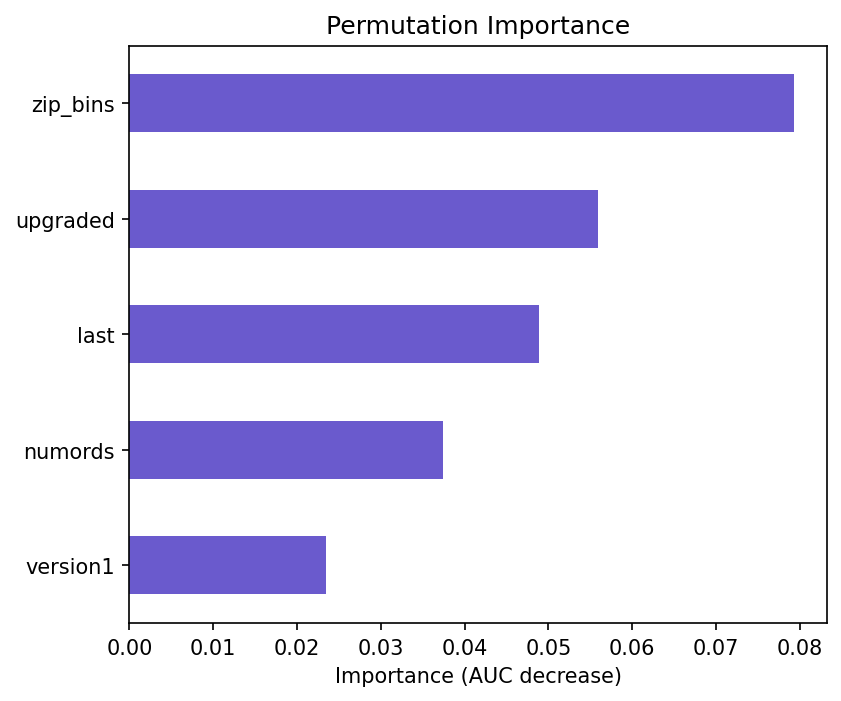

In [30]:
clf4 = rsm.model.mlp(
    data={"fpb_train": intuit75k[intuit75k.training == 1]},
    rvar="res1",
    lev="Yes",
    evar=evar2,
    hidden_layer_sizes=(5,),
    mod_type="classification",
)
clf4.summary(), clf4.plot('vimp')

### Generating Predictions for `clf3` and `clf4`

We generate predictions from both **neural network models (`clf3` and `clf4`)**.

#### **Why This Matters:**
- We need to compare **how well `clf3` and `clf4` perform**.
- By storing predictions, we can later analyze **which model is more accurate**.

#### **Expected Outcome:**
- Both `pred_nn3` and `pred_nn4` columns should be added to `intuit75k`.
- These predictions will be used in final model evaluation.


In [31]:
intuit75k['pred_nn3'] = clf3.predict(intuit75k)['prediction']
intuit75k['pred_nn4'] = clf4.predict(intuit75k)['prediction']

### Gain Chart for Model `clf3`

We generate a **Gain Chart (ROC Curve)** to evaluate how well model `clf3` ranks customers by their likelihood to respond.

#### **Why This Is Important?**
- Gain Charts **compare the model’s ranking ability** for responders vs. non-responders.
- A **steeper curve** means the model is effectively ranking likely responders higher.

#### **What This Does:**
- Uses `rsm.gains_plot()` to create the Gain Chart.
- Compares performance on **training (`train`) and test (`test`) sets**.

#### **Expected Outcome:**
- The **test curve should closely follow the train curve**.
- A significant gap between training and test curves may indicate **overfitting**.


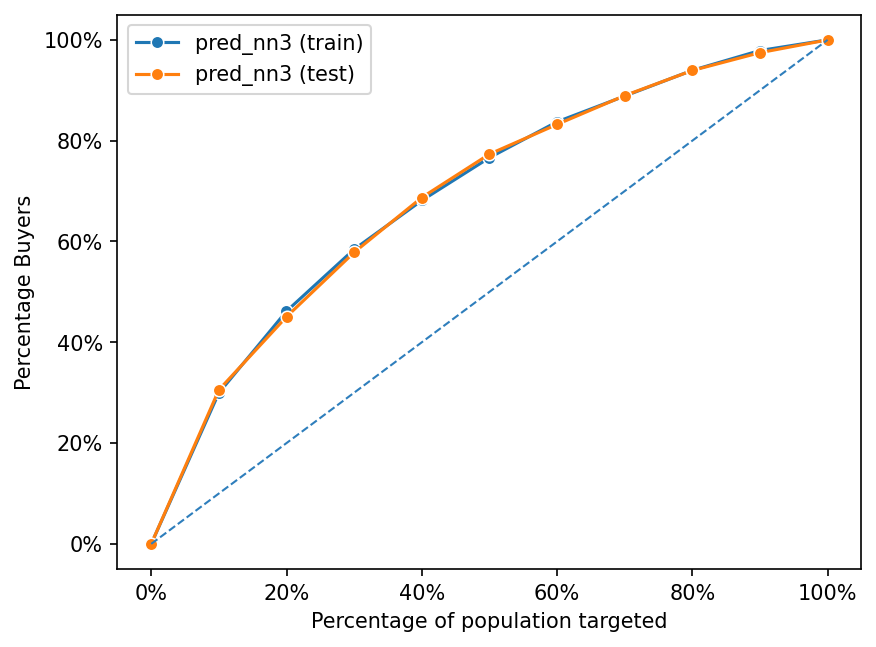

In [32]:
## gain chart of model clf3
dct = {"train": intuit75k[intuit75k['training'] == 1], "test": intuit75k[intuit75k['training'] == 0]}
fig3 = rsm.gains_plot(dct, "res1", "Yes", "pred_nn3")

### Gain Chart for Model `clf4`

We generate a **Gain Chart** for our final model (`clf4`), comparing its ranking ability for responders.

#### **Why This Is Important?**
- If `clf4` was correctly tuned, its Gain Chart should **outperform `clf3`**.
- We should see a **steeper initial rise** in the test curve compared to `clf3`.

#### **Expected Outcome:**
- If `clf4`’s test curve is **closer to its training curve** than `clf3`, it suggests **less overfitting**.


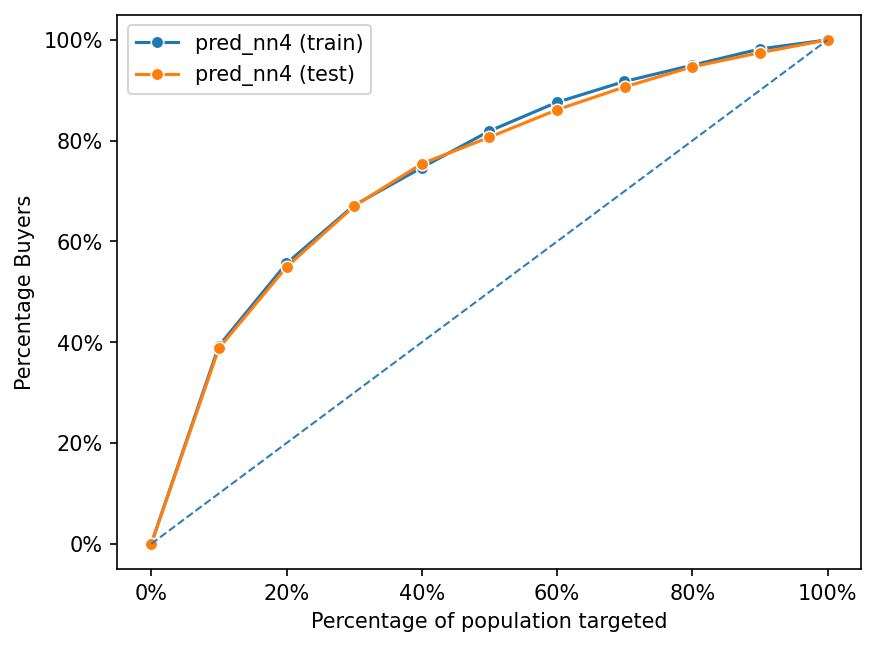

In [33]:
## gain chart of model clf4
fig4 = rsm.gains_plot(dct, "res1", "Yes", "pred_nn4")

## Logistic Regression

### Training a Logistic Regression Model (`lr1`)

To compare neural network performance with a simpler model, we train a **Logistic Regression Model (`lr1`)**.

#### **Why Logistic Regression?**
- Provides a **baseline comparison** against neural networks.
- Offers **interpretability**, showing how each feature influences response probability.

#### **Key Model Parameters:**
- **Dataset (`train_set`)**: Uses training data.
- **Response Variable (`rvar`)**: `res1_yes`, indicating customer response.
- **Feature Variables (`evar`)**: Uses the same predictors as neural networks.
- **Variance Inflation Factor (`VIF`)**: Assesses **multicollinearity** between features.

#### **Expected Outcome:**
- A **summary table** with regression coefficients and significance.
- **Prediction Plot (`plot('pred')`)** visualizing probabilities.
- **Feature Importance Plot (`plot('vimp')`)** highlighting key predictors.


Logistic regression (GLM)
Data                 : Not provided
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded, sex
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                 OR     OR%  coefficient  std.error  z.value p.value     
Intercept     0.048  -95.2%        -3.05      0.070  -43.645  < .001  ***
sex[Male]     0.987   -1.3%        -0.01      0.052   -0.249   0.804     
sex[Unknown]  0.991   -0.9%        -0.01      0.074   -0.118   0.906     
zip_bins      0.946   -5.4%        -0.06      0.004  -14.931  < .001  ***
bizflag       1.047    4.7%         0.05      0.048    0.964   0.335     
numords       1.321   32.1%         0.28      0.023   12.010  < .001  ***
dollars       1.082    8.2%         0.08      0.022    3.638  < .001  ***
last          0.666  -33.4%        -0.41      0.023  -17.959  < .001  ***
sincep

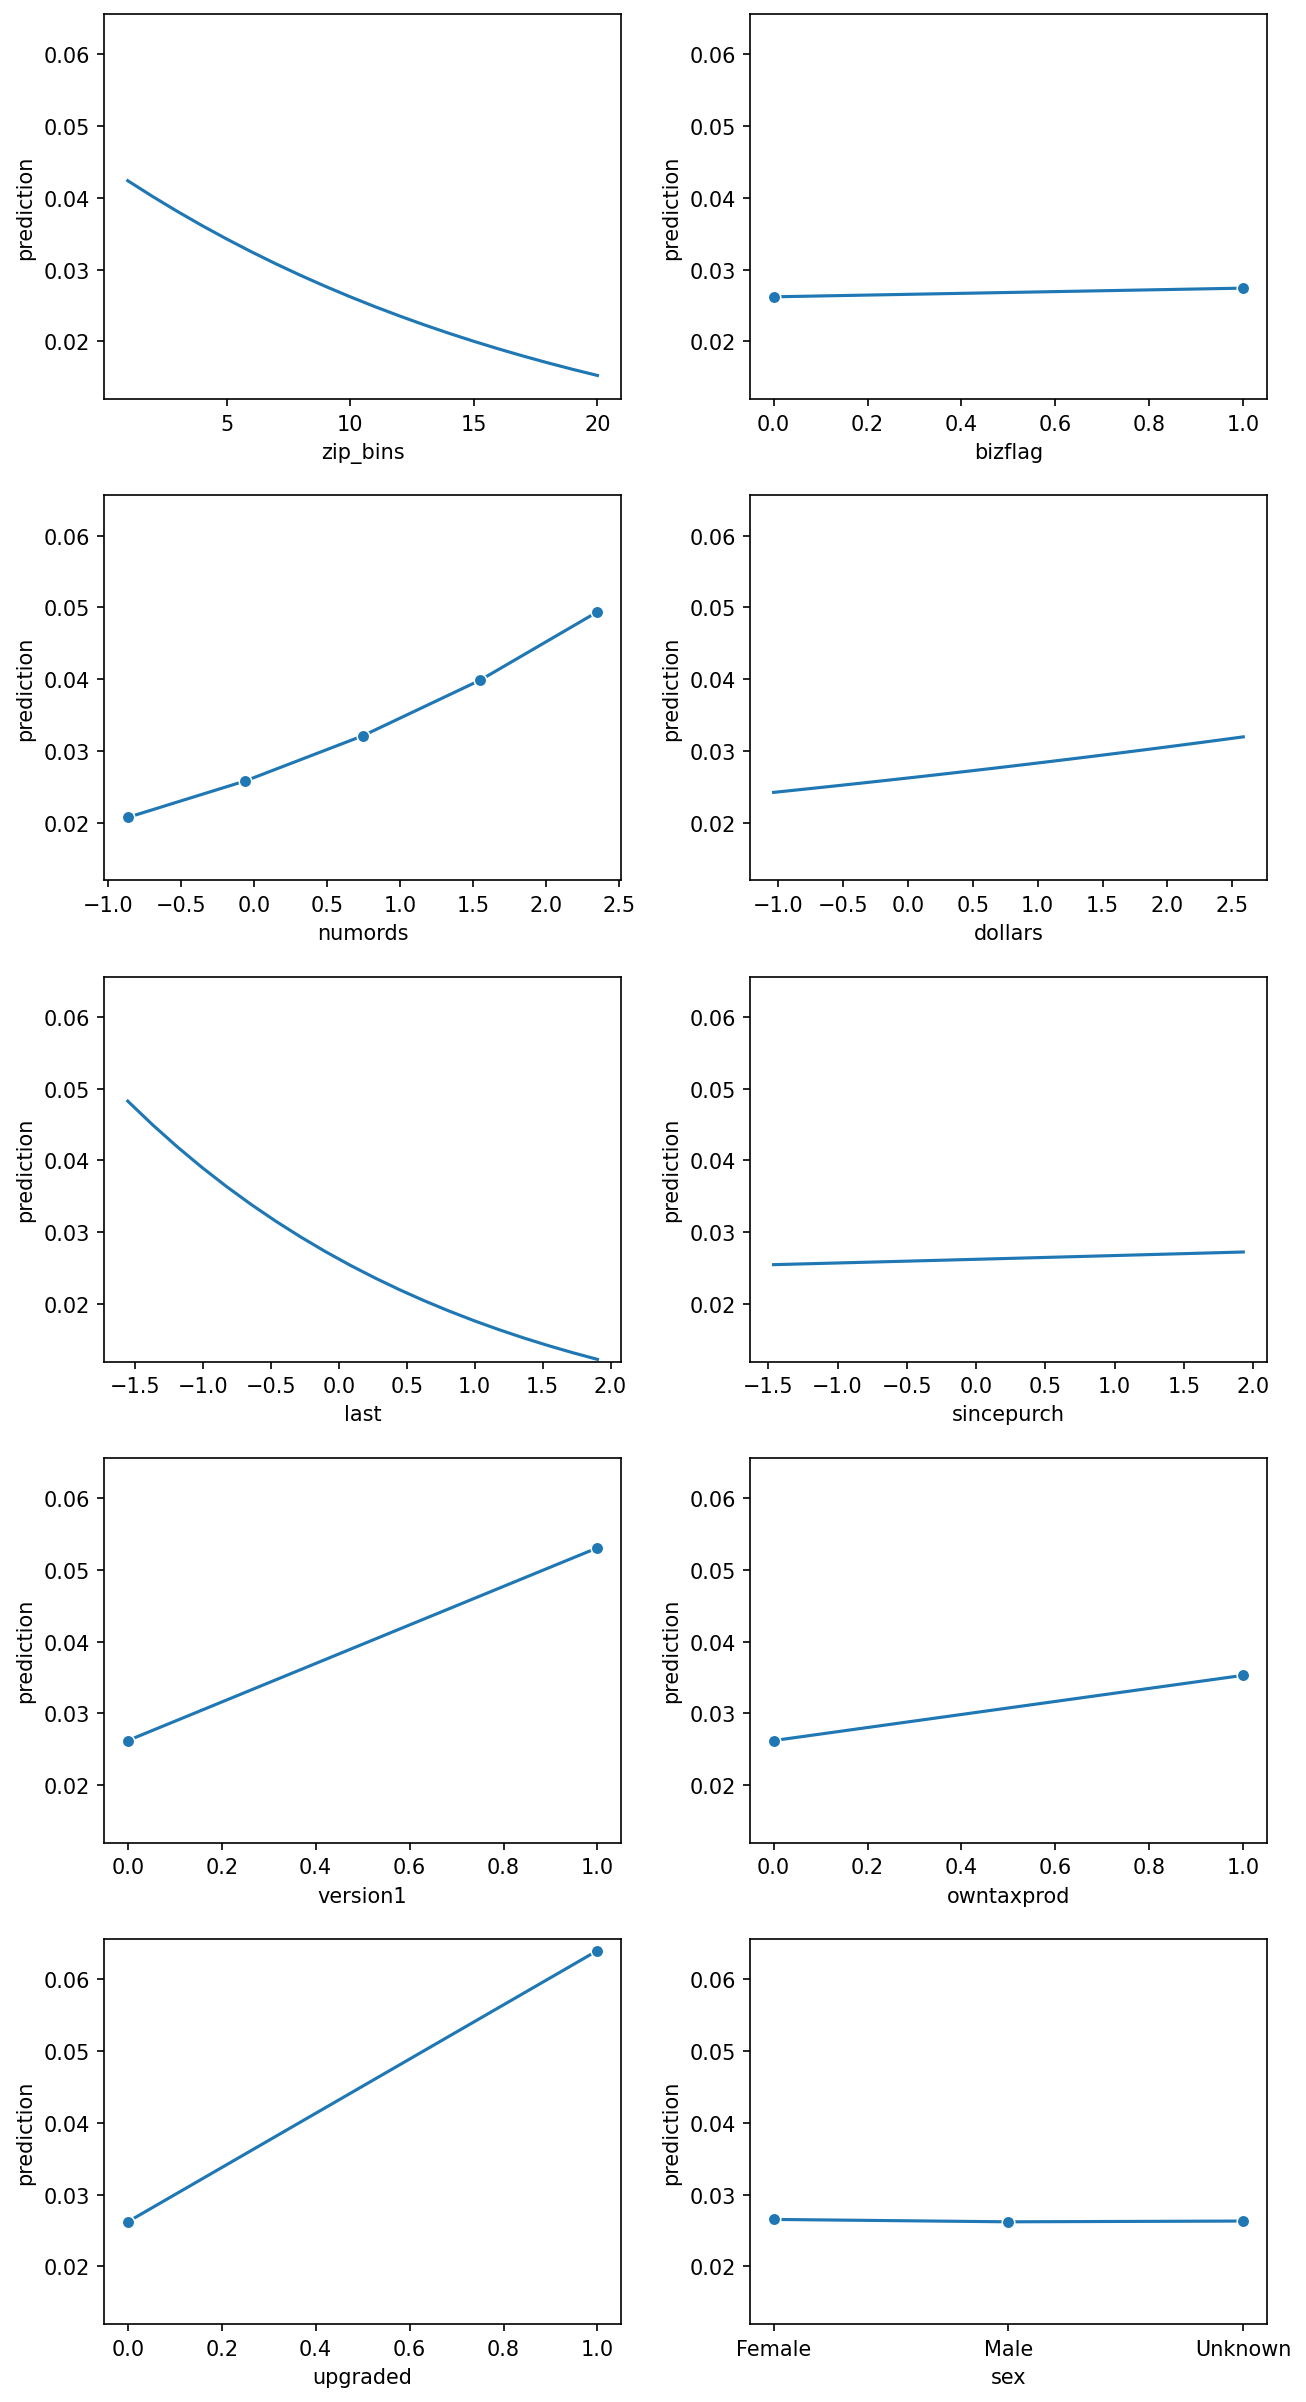

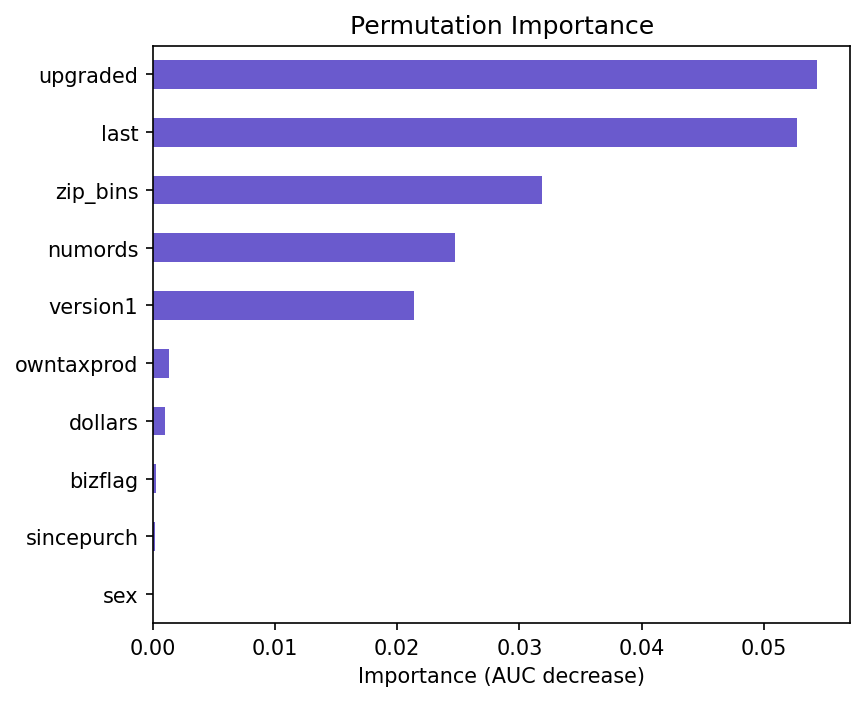

In [34]:
lr1 = rsm.model.logistic(
    data = train_set,
    rvar = 'res1_yes', lev = 1,
    evar = evar
)

lr1.summary(vif = True)

lr1.plot('pred')
lr1.plot('vimp')

### Standardized Logistic Regression Model (`lr1_std`)

We train a **logistic regression model** on the **standardized dataset (`data_std_train`)**.

#### **Why Standardize?**
- Ensures that all features are on the **same scale**, improving model stability.
- Reduces the impact of large numerical values, making coefficients more interpretable.

#### **Expected Outcome:**
- Results should be **similar to `lr1`**, but with **better numerical stability**.
- The **feature importance plot (`plot('vimp')`)** should remain consistent.

Logistic regression (GLM)
Data                 : Not provided
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded, sex
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                 OR     OR%  coefficient  std.error  z.value p.value     
Intercept     0.047  -95.3%        -3.05      0.070  -43.713  < .001  ***
sex[Male]     0.987   -1.3%        -0.01      0.052   -0.249   0.804     
sex[Unknown]  0.991   -0.9%        -0.01      0.074   -0.118   0.906     
zip_bins      0.946   -5.4%        -0.06      0.004  -14.931  < .001  ***
bizflag       1.047    4.7%         0.05      0.048    0.964   0.335     
numords       1.321   32.1%         0.28      0.023   12.010  < .001  ***
dollars       1.082    8.2%         0.08      0.022    3.638  < .001  ***
last          0.666  -33.4%        -0.41      0.023  -17.959  < .001  ***
sincep

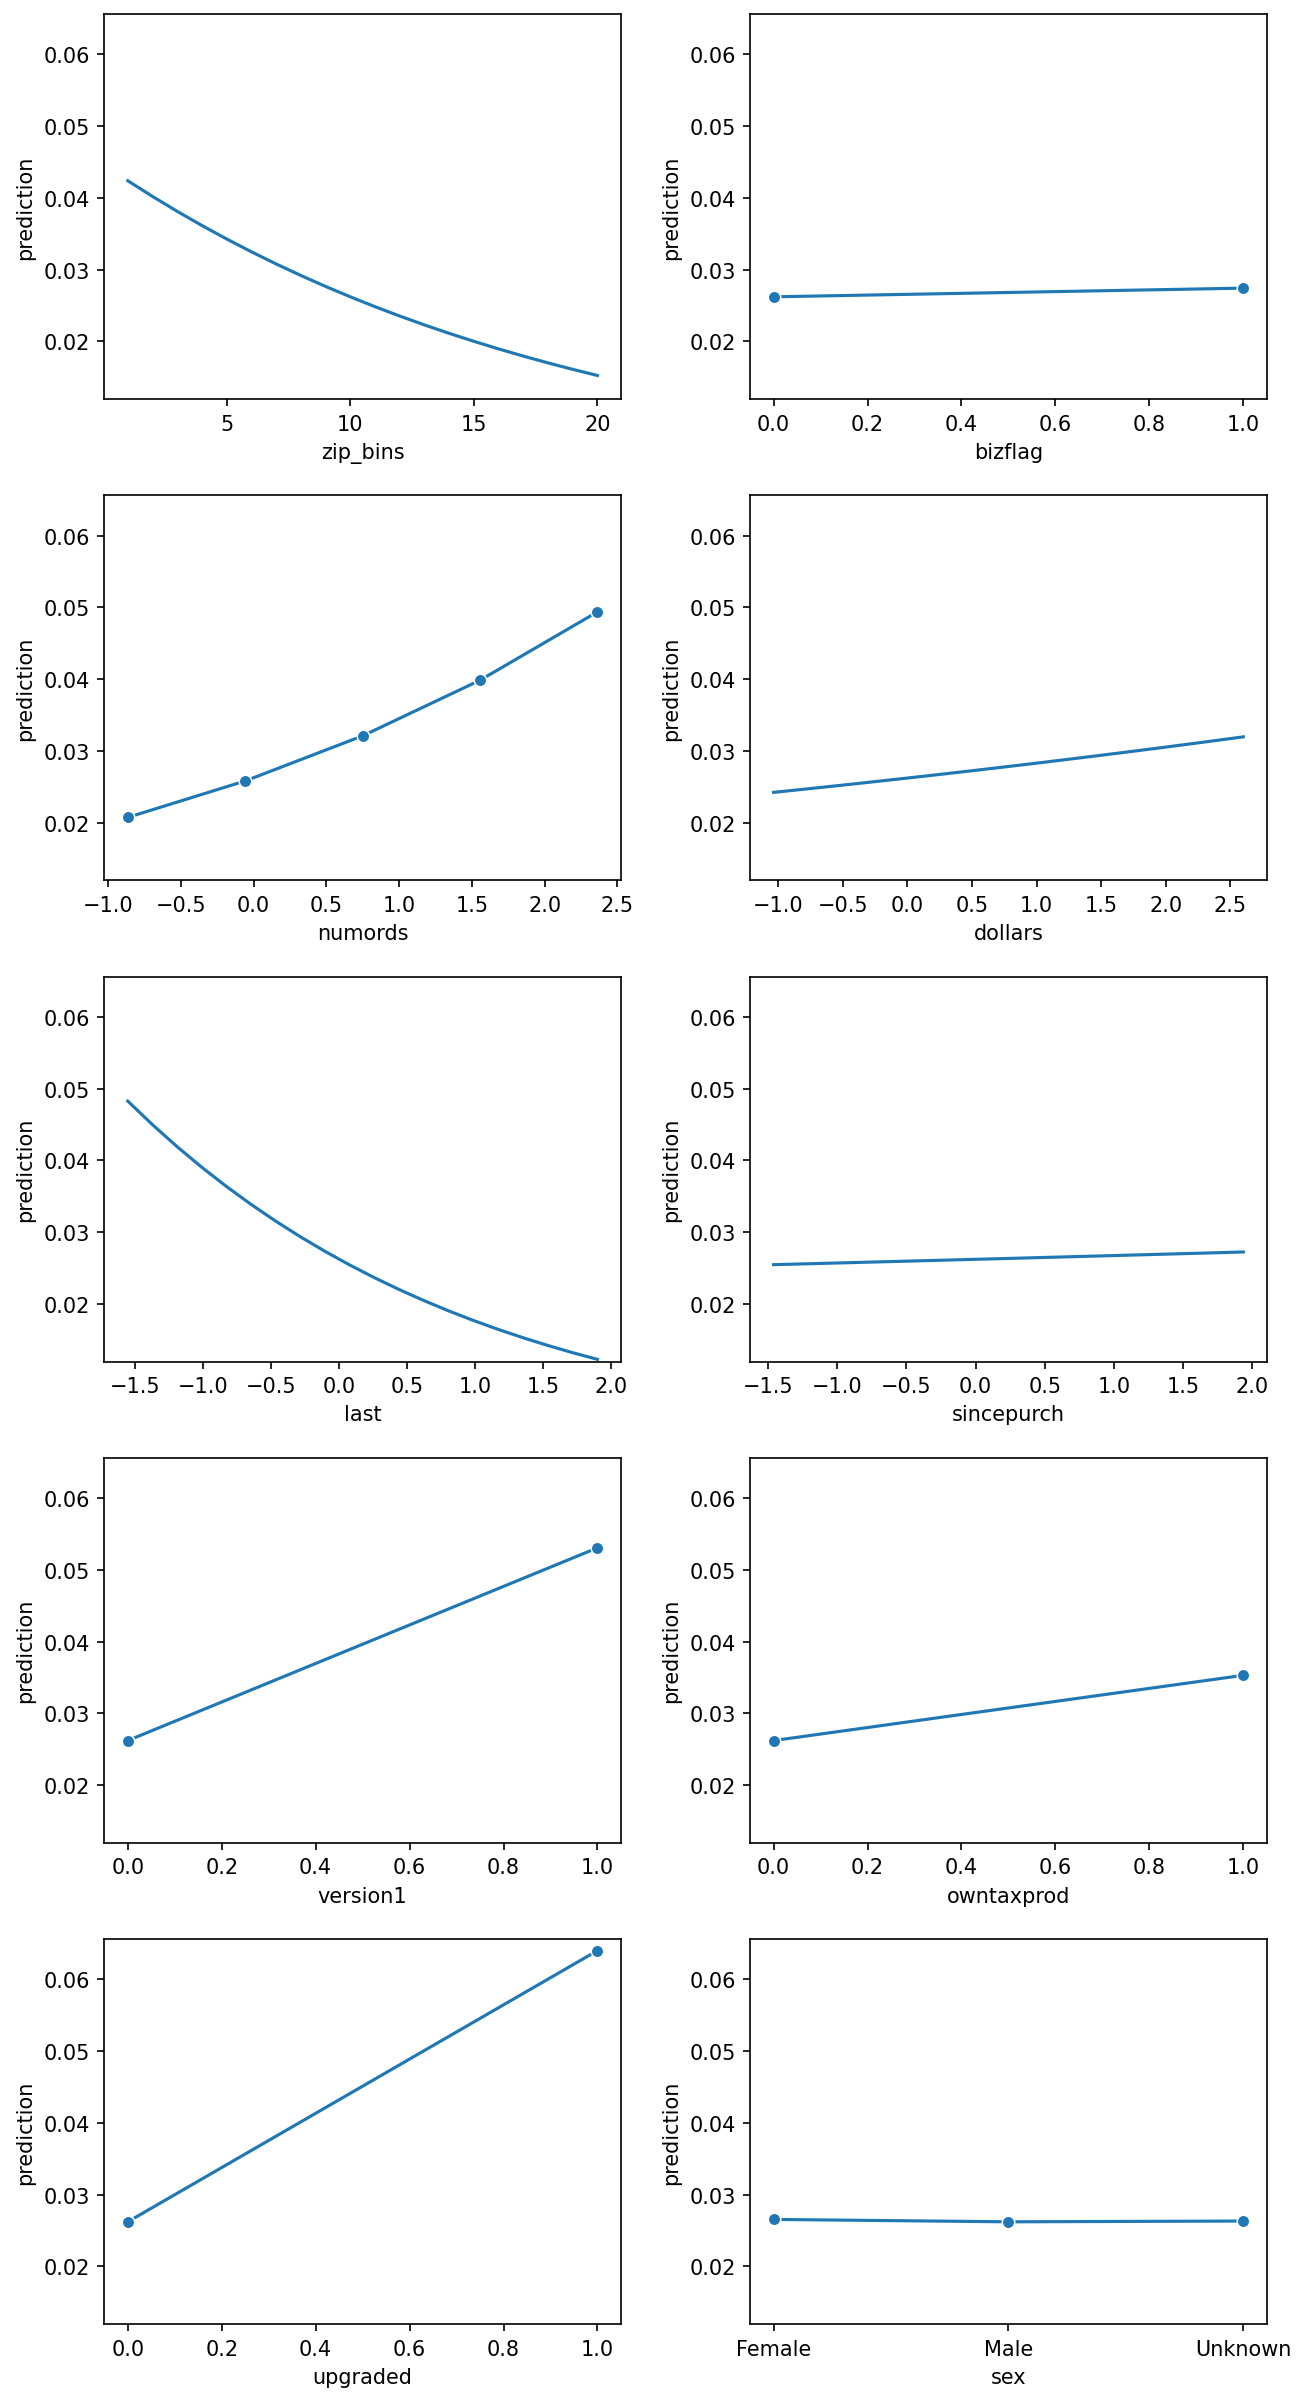

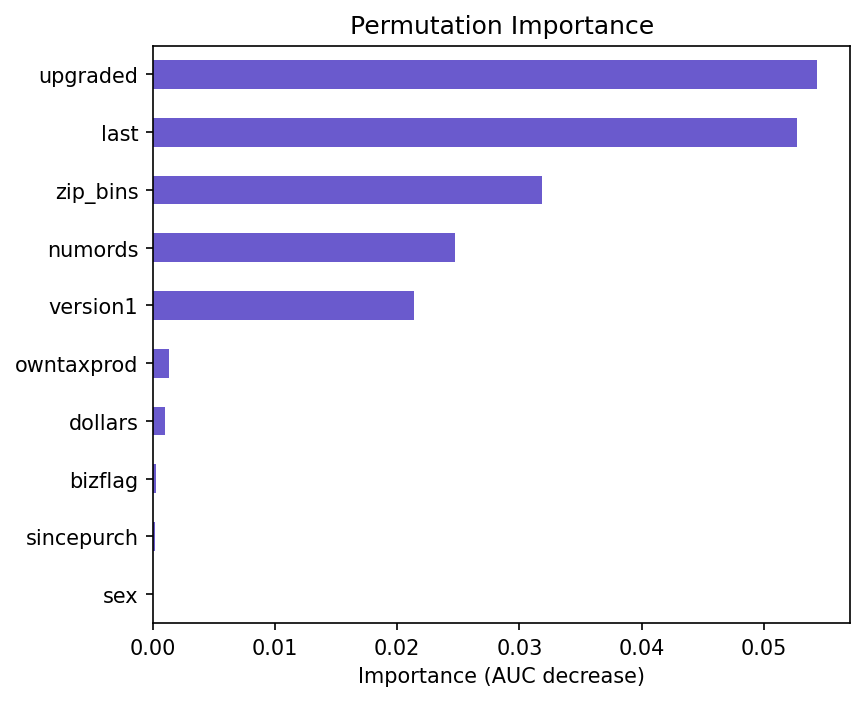

In [36]:
from sklearn.preprocessing import StandardScaler

# Standardize the numeric columns in train_set
scaler = StandardScaler()
data_std_train = train_set.copy()
data_std_train[num_cols] = scaler.fit_transform(train_set[num_cols])

lr1_std = rsm.model.logistic(
    data = data_std_train,
    rvar = 'res1_yes', lev = 1,
    evar = evar
)

lr1_std.summary(vif = True)
lr1_std.plot('pred')
lr1_std.plot('vimp')

### Gains Plot for Logistic Regression (`lr1`)

We generate a **Gain Chart** to evaluate the performance of the logistic regression model (`lr1`).

#### **Why Use a Gains Plot?**
- A **steeper curve** indicates that the model is better at ranking positive cases.
- Helps compare performance against neural networks (`clf3`, `clf4`).

#### **Key Steps:**
1. Generate predictions (`pred_logit1`) from the logistic regression model.
2. Use `rsm.gains_plot()` to visualize performance across **training** and **test** sets.

#### **Expected Outcome:**
- The test curve should **closely follow** the training curve.
- If there's a **large gap**, the model may be **overfitting**.


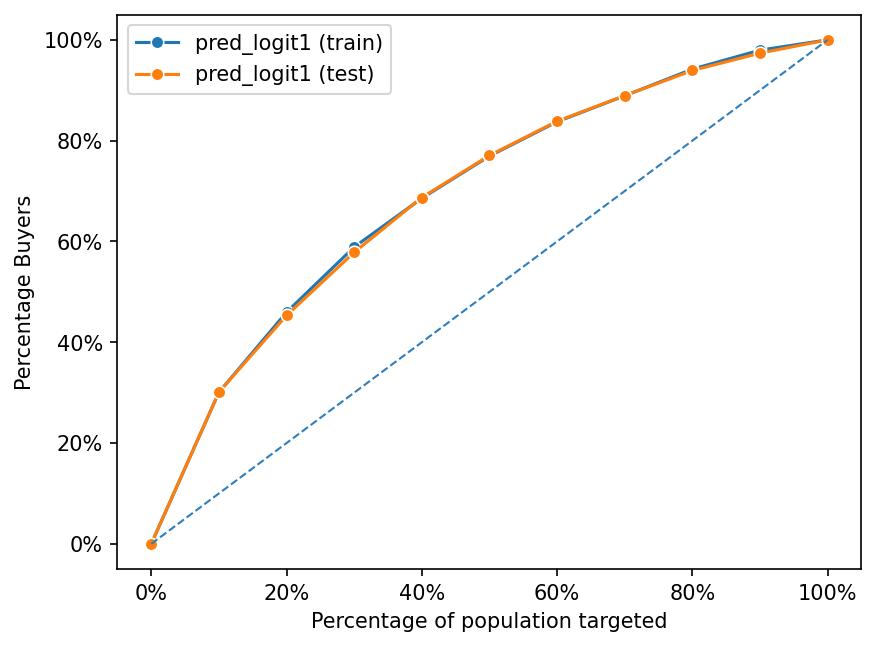

In [123]:
## gains plot
intuit75k['pred_logit1'] = lr1.predict(intuit75k)['prediction']

dct = {"train": intuit75k[intuit75k['training'] == 1], "test": intuit75k[intuit75k['training'] == 0]}
fig1 = rsm.gains_plot(dct, "res1", "Yes", "pred_logit1")

### Defining a New Feature Set (`evar3`)

We refine the **feature selection** for logistic regression by selecting the most relevant predictors.

#### **Why Reduce Features?**
- Simplifies the model, improving interpretability.
- Reduces risk of **multicollinearity** and overfitting.

#### **Selected Features (`evar3`):**
- **`zip_bins`** → Location-based customer segmentation.
- **`upgraded`** → Tracks previous QuickBooks upgrades.
- **`last`** → Time since the last purchase.
- **`numords`** → Number of previous orders.
- **`version1`** → Indicates whether the customer has QuickBooks version 1.

#### **Expected Outcome:**
- This refined feature set should help **improve model efficiency** without losing predictive power.


In [124]:
evar3 = ['zip_bins','upgraded','last','numords','version1']

### Training a Logistic Regression Model with `evar3`

We train a **new logistic regression model (`lr_2`)** using the optimized feature set.

#### **Why Train a New Model?**
- A **simpler feature set** improves model efficiency.
- The previous model (`lr1`) used more features, which may not all be necessary.

#### **Key Differences from `lr1`:**
- Uses only **five key features (`evar3`)** instead of the full set (`evar`).
- Expected to perform **similarly or better** with less complexity.

#### **Expected Outcome:**
- A **summary table** with regression coefficients and significance.
- **Feature importance visualization (`plot('vimp')`)** for model interpretation.


Logistic regression (GLM)
Data                 : Not provided
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, upgraded, last, numords, version1
Null hyp.: There is no effect of x on res1
Alt. hyp.: There is an effect of x on res1

              OR     OR%  coefficient  std.error  z.value p.value     
Intercept  0.054  -94.6%        -2.93      0.069  -42.412  < .001  ***
zip_bins   0.946   -5.4%        -0.06      0.004  -14.892  < .001  ***
upgraded   2.662  166.2%         0.98      0.049   19.811  < .001  ***
last       0.958   -4.2%        -0.04      0.002  -17.999  < .001  ***
numords    1.306   30.6%         0.27      0.015   17.605  < .001  ***
version1   2.132  113.2%         0.76      0.051   14.710  < .001  ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Pseudo R-squared (McFadden): 0.07
Pseudo R-squared (McFadden adjusted): 0.069
Area under the RO Curve (AUC): 0.707
Log-likelihood: -9343.617, AIC: 18699.233, BIC: 1875

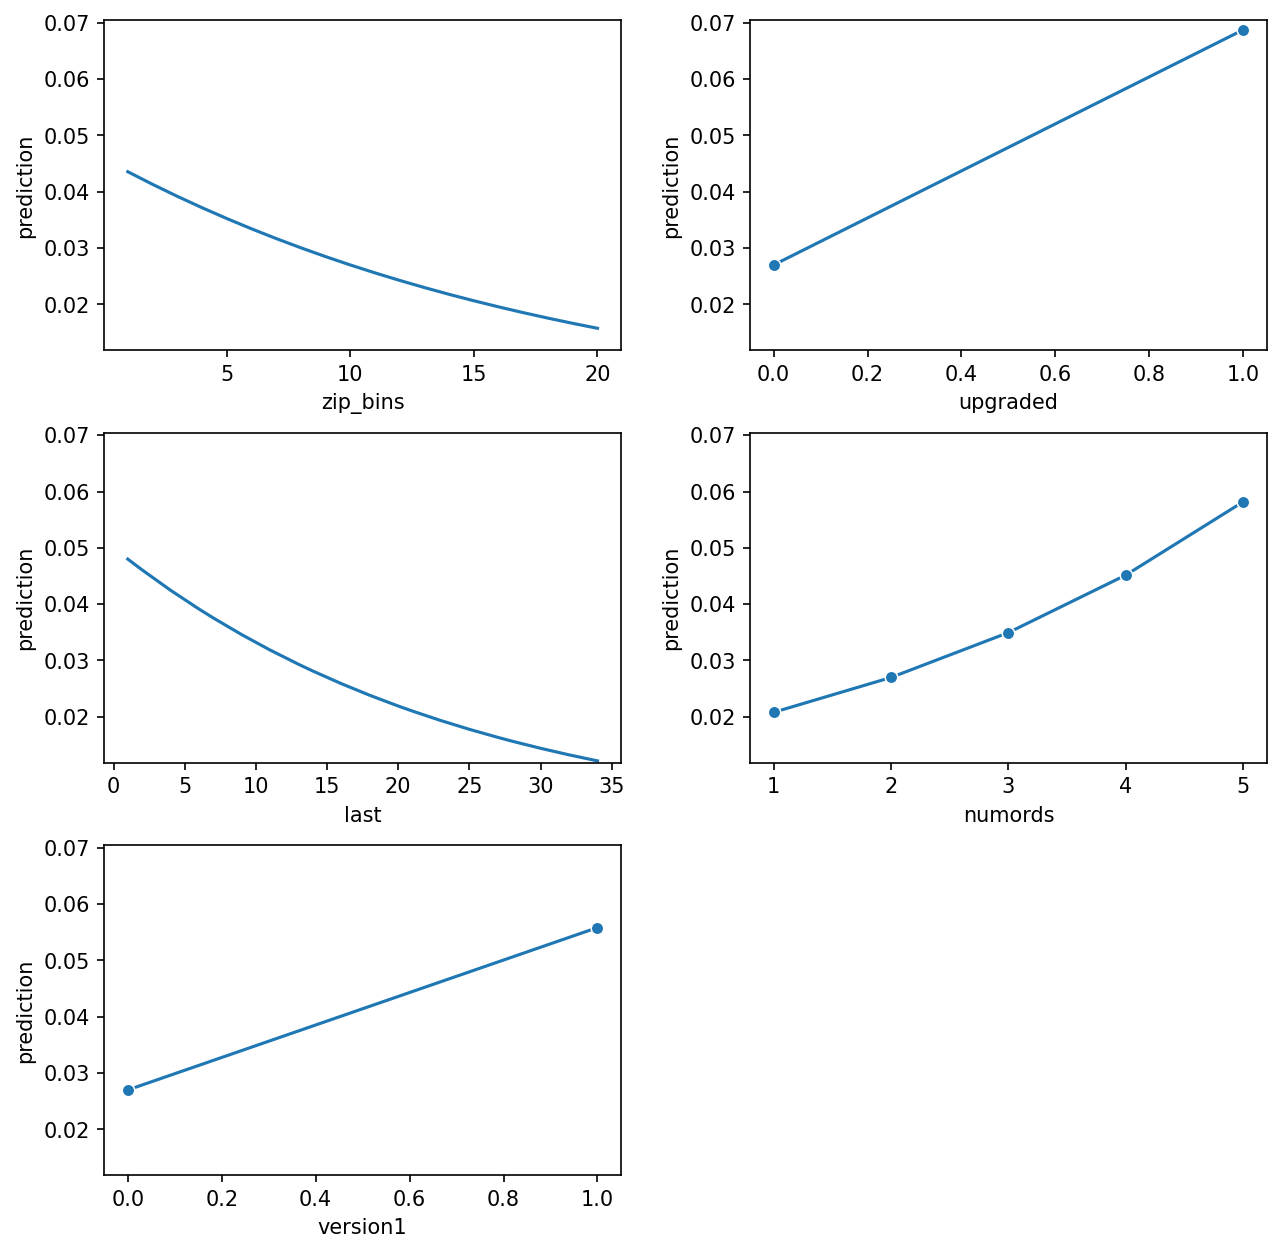

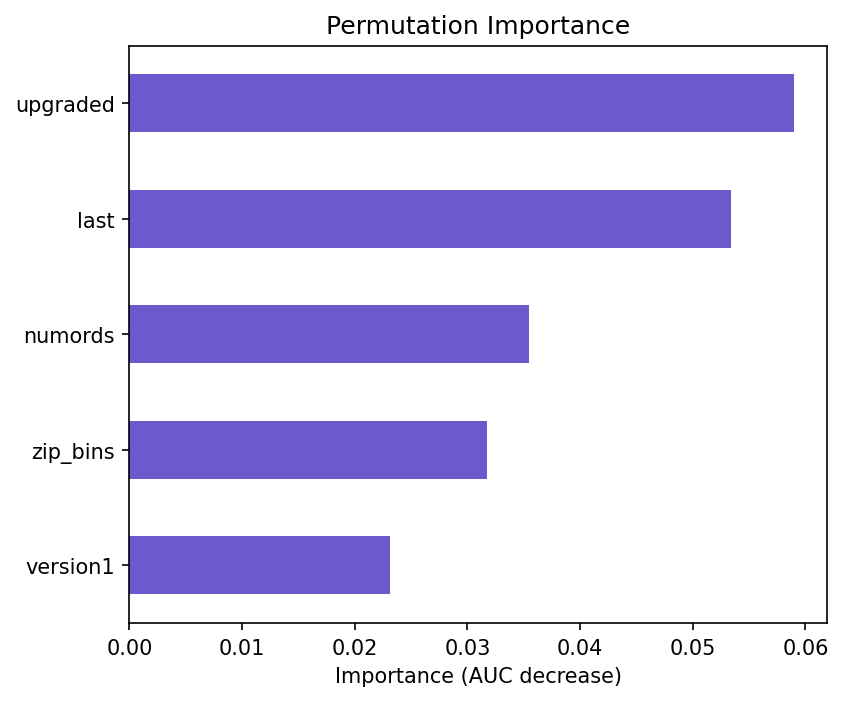

In [125]:
## using new evar3 to train the model
lr_2 = rsm.model.logistic(
    data = train_set,
    rvar = 'res1',
    lev = 'Yes',
    evar = evar3,
)

lr_2.summary(vif = True)

lr_2.plot('pred')
lr_2.plot('vimp')

### Gains Plot for Logistic Regression (`lr_2`)

We generate a **Gain Chart** to compare performance of the refined logistic regression model (`lr_2`).

#### **Why This Matters:**
- Helps compare performance of `lr_2` vs. the previous logistic model (`lr1`).
- If `lr_2` performs similarly with **fewer features**, it indicates **better model efficiency**.

#### **Expected Outcome:**
- The test curve should be **close to the train curve**.
- A significant improvement over `lr1` would confirm that `evar3` is a better feature set.

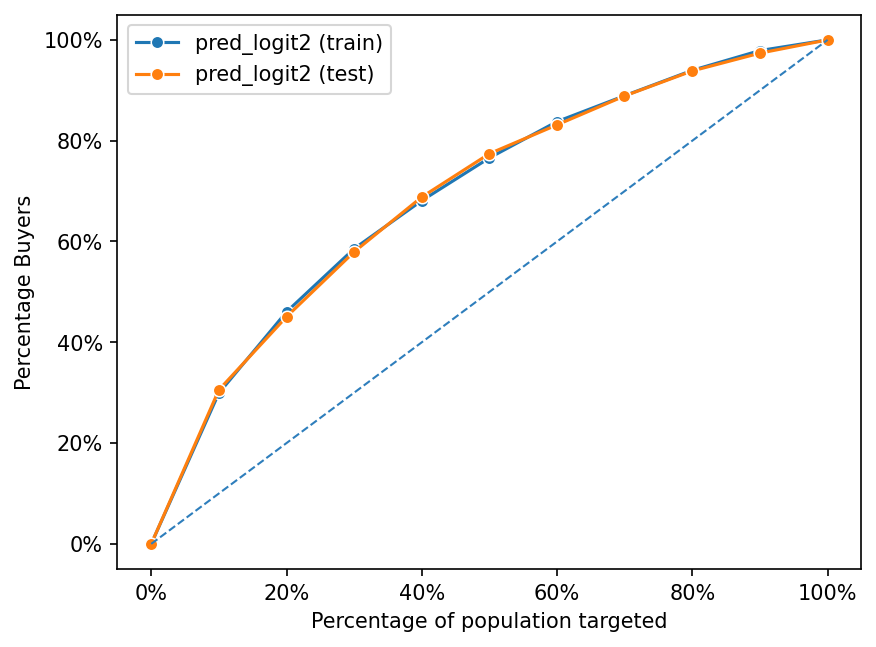

In [126]:
## gains plot
intuit75k['pred_logit2'] = lr_2.predict(intuit75k)['prediction']

dct = {"train": intuit75k[intuit75k['training'] == 1], "test": intuit75k[intuit75k['training'] == 0]}
fig2 = rsm.gains_plot(dct, "res1", "Yes", "pred_logit2")

### Training Logistic Regression with Interaction Terms (`lr_hand`)

We train a new **logistic regression model (`lr_hand`)** that includes **interaction terms**.

#### **Why Add Interaction Terms?**
- **`zip_bins:numords`** → Captures how different geographic regions affect purchase frequency.
- **`version1:numords`** → Captures how QuickBooks version history influences purchasing power.

#### **Expected Outcome:**
- If these interactions improve AUC, it confirms that **purchase frequency and location influence response probability**.


Logistic regression (GLM)
Data                 : Not provided
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, upgraded, last, numords, version1
Null hyp.: There is no effect of x on res1
Alt. hyp.: There is an effect of x on res1

                     OR     OR%  coefficient  std.error  z.value p.value     
Intercept         0.079  -92.1%        -2.53      0.093  -27.262  < .001  ***
zip_bins          0.930   -7.0%        -0.07      0.008   -9.495  < .001  ***
upgraded          2.646  164.6%         0.97      0.049   19.747  < .001  ***
last              0.958   -4.2%        -0.04      0.002  -18.065  < .001  ***
numords           1.118   11.8%         0.11      0.030    3.711  < .001  ***
version1          0.919   -8.1%        -0.08      0.105   -0.807    0.42     
zip_bins:numords  1.007    0.7%         0.01      0.003    2.623   0.009   **
version1:numords  1.376   37.6%         0.32      0.033    9.552  < .001  ***

Signif. codes:  0 '***' 0.

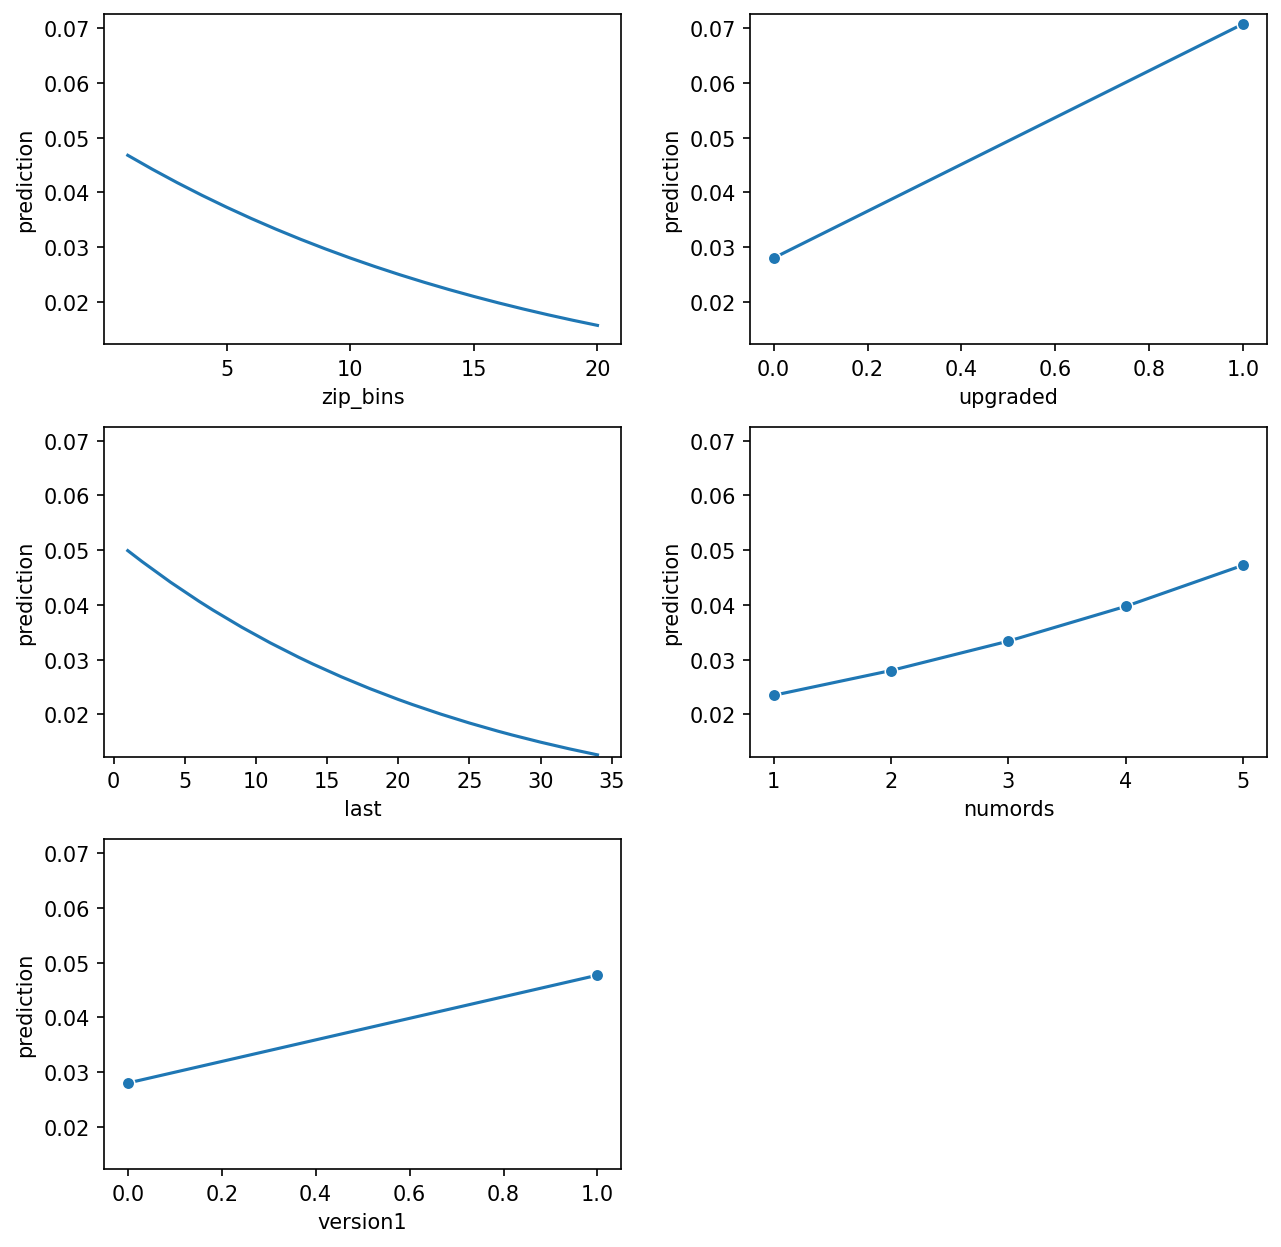

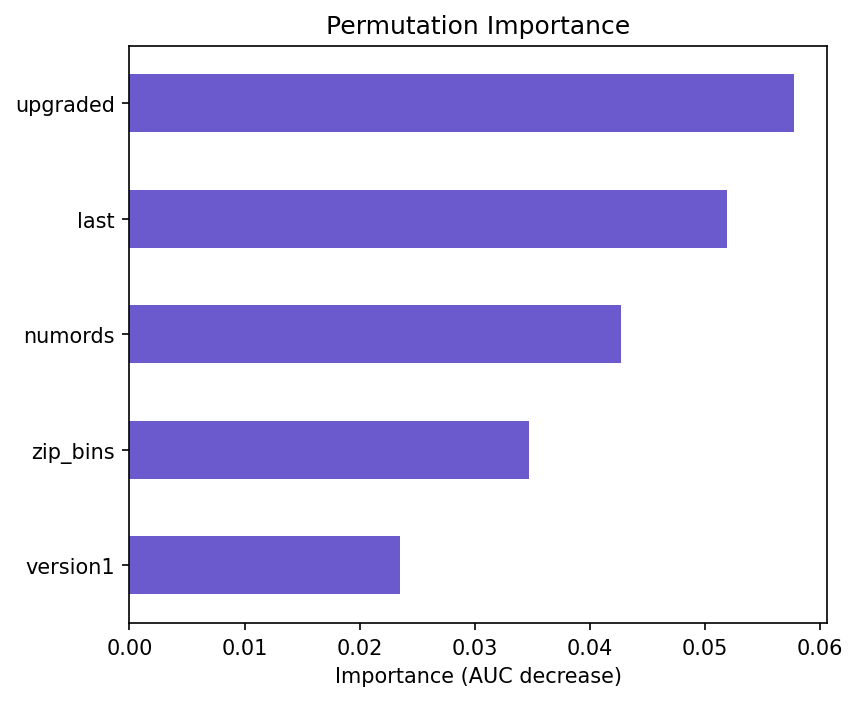

In [127]:
lr_hand = rsm.model.logistic(
    data = train_set,
    rvar = 'res1',
    lev = 'Yes',
    evar = evar3,
    ivar = [
            'zip_bins:numords',
            ## we want to interaction terms "zip_bins:numords" because we think that people in different zip_bins have different income levels, and they may have different purchasing power.
            'version1:numords',
            ## we want to interaction terms "version1:numords" because we think that people who have used version1 may have different purchasing power.
    ]
)


lr_hand.summary(vif = True)

lr_hand.plot('pred')
lr_hand.plot('vimp')

### Gains Plot for Logistic Regression with Interaction Terms (`lr_hand`)

We generate a **Gains Plot** to evaluate whether interaction terms improve logistic regression performance.

#### **Why This Is Important?**
- Helps us determine if adding **interaction terms** (`zip_bins:numords`, `version1:numords`) improves prediction accuracy.
- If `lr_hand` shows a better curve than `lr_2`, it suggests that these **interaction effects are meaningful**.

#### **Expected Outcome:**
- If the test curve is **closer to the train curve**, it indicates **less overfitting**.

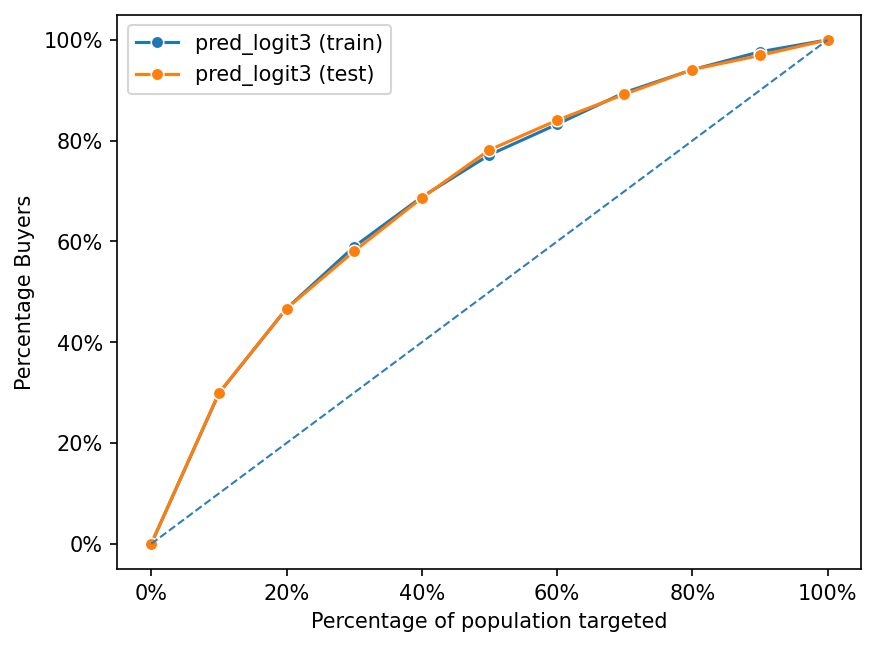

In [128]:
## gains plot
intuit75k['pred_logit3'] = lr_hand.predict(intuit75k)['prediction']

dct = {"train": intuit75k[intuit75k['training'] == 1], "test": intuit75k[intuit75k['training'] == 0]}
fig3 = rsm.gains_plot(dct, "res1", "Yes", "pred_logit3")

### Comparing Gains Plots for Multiple Models

We generate a **combined Gains Plot** to compare performance across three different models:
- **`pred_nn2`** → Predictions from the second neural network (`clf2`).
- **`pred_nn4`** → Predictions from the final optimized neural network (`clf4`).
- **`pred_logit3`** → Predictions from logistic regression with interaction terms (`lr_hand`).

#### **Why Compare Models?**
- Helps visualize whether **neural networks outperform logistic regression**.
- If logistic regression (`pred_logit3`) is **close to** neural network (`pred_nn4`), it suggests simpler models may be effective.

#### **Expected Outcome:**
- **If neural networks outperform logistic regression**, the NN curves will be steeper.
- If all models perform similarly, logistic regression may be **sufficient** for predicting responses.


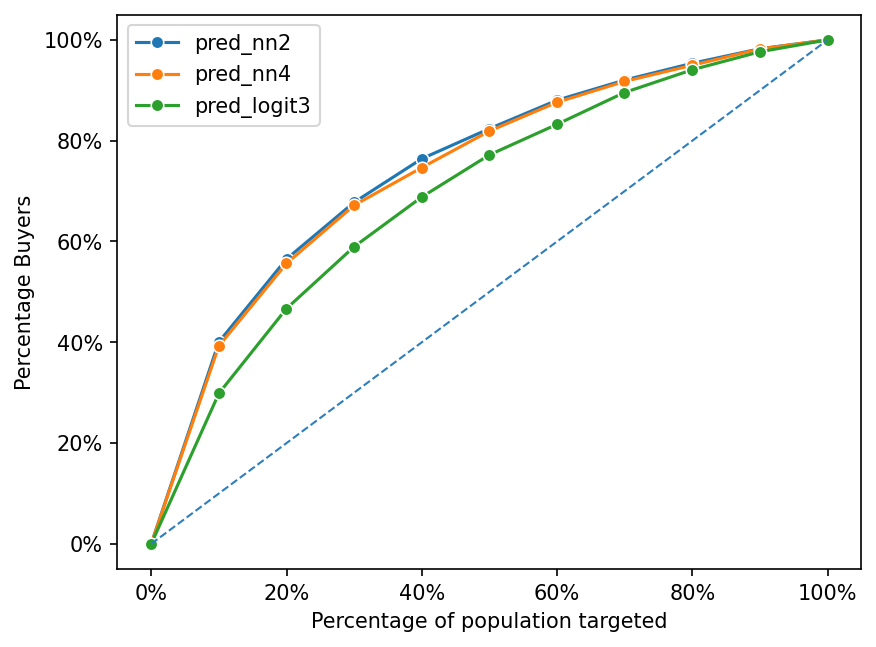

In [129]:
fig = rsm.gains_plot(intuit75k[intuit75k['training'] == 1], "res1", "Yes", ["pred_nn2", "pred_nn4", "pred_logit3"])

### Final Gains Plot on the Entire Dataset

We generate a final **Gains Plot** on the full dataset (both training and test sets) to summarize model performance.

#### **Why This Matters?**
- Provides an **overall evaluation** of how well each model performs.
- Helps determine which model should be **used for decision-making**.

#### **Expected Outcome:**
- The best-performing model should have the **steepest curve**, indicating better ranking ability.

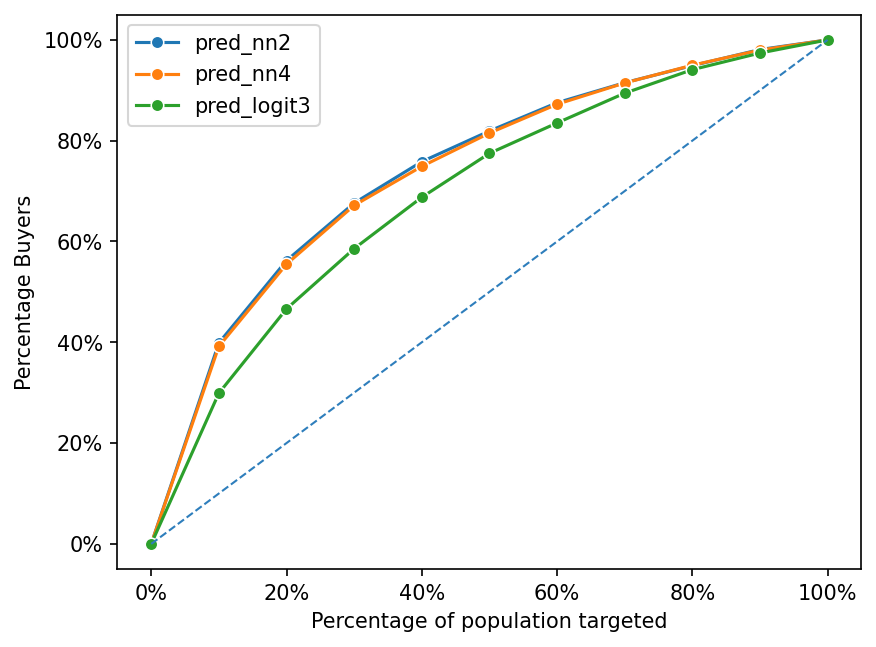

In [130]:
fig = rsm.gains_plot(intuit75k, "res1", "Yes", ["pred_nn2","pred_nn4", "pred_logit3"])

## Profit calucation

In [131]:
mail_cost = 1.41
margin = 60 
total_business = 801821 - 38487

In here we calculate the break-even point using the mail cost the margin.

In [132]:
break_even = mail_cost / margin
break_even

0.0235

Mark the target users for each model using break-even as the threshold.

In [133]:
intuit75k['target_logit'] = intuit75k['pred_logit3'] > break_even
intuit75k['target_nn2'] = intuit75k['pred_nn2'] > break_even
intuit75k['target_nn4'] = intuit75k['pred_nn4'] > break_even

In [134]:
intuit75k_test = intuit75k[intuit75k.training == 0]

## Test set profit


Calculate the profit from test set using different models to see which model is the best.

__logistic regression__:

In [135]:
target_logit = intuit75k_test['target_logit'].sum() # number of target users in test set using the logit model
response_logit_set = intuit75k_test[(intuit75k_test.target_logit == True)&(intuit75k_test.res1_yes == 1)]# data set of target users who responded in test set
response_logit = response_logit_set.shape[0] #number of target users who responded
response_rate_logit = (response_logit / target_logit) * 0.5 # response rate of target users which is half of the actual first wave response rate
cost_logit = target_logit * mail_cost # cost of mailing 
margin_logit = response_rate_logit * target_logit * margin # margin from the target users
profit_logit_test = margin_logit - cost_logit # profit from the target users 
print(f'target_logit : {target_logit}\n'
    f'response_logit : {response_logit}\n'
    f'response_rate_logit : {response_rate_logit}\n'
    f'cost_logit : {cost_logit}\n'
    f'margin_logit : {margin_logit}\n'
    f'profit_logit : {profit_logit_test}\n')

target_logit : 15924
response_logit : 987
response_rate_logit : 0.03099095704596835
cost_logit : 22452.84
margin_logit : 29610.0
profit_logit : 7157.16



__Neural network 2: clf2__

In [136]:
target_neural = intuit75k_test['target_nn2'].sum() # number of target users in test set using the nn2 model
response_neural_set = intuit75k_test[(intuit75k_test.target_nn2 == True)&(intuit75k_test.res1_yes == 1)] # data set of target users who responded in test set
response_neural = response_neural_set.shape[0] #number of target users who responded
response_rate_neural = (response_neural / target_neural) * 0.5 # response rate of target users which is half of the actual first wave response rate
cost_neural = target_neural * mail_cost # cost of mailing 
margin_neural = response_rate_neural * target_neural * margin # margin from the target users 
profit_neural_test_2 = margin_neural - cost_neural # profit from the target users
print(f'target_neural : {target_neural}\n'
    f'response_neural : {response_neural}\n'
    f'response_rate_neural : {response_rate_neural}\n'
    f'cost_neural : {cost_neural}\n'
    f'margin_neural : {margin_neural}\n'
    f'profit_neural : {profit_neural_test_2}\n')

target_neural : 13391
response_neural : 952
response_rate_neural : 0.03554626241505489
cost_neural : 18881.309999999998
margin_neural : 28560.0
profit_neural : 9678.690000000002



__Neural network 4: clf4__

In [137]:
target_neural = intuit75k_test['target_nn4'].sum() # number of target users in test set using the nn4 model
response_neural_set = intuit75k_test[(intuit75k_test.target_nn4 == True)&(intuit75k_test.res1_yes == 1)] # data set of target users who responded in test set
response_neural = response_neural_set.shape[0] #number of target users who responded
response_rate_neural = (response_neural / target_neural) * 0.5 # response rate of target users which is half of the actual first wave response rate
cost_neural = target_neural * mail_cost # cost of mailing 
margin_neural = response_rate_neural * target_neural * margin # margin from the target users 
profit_neural_test_4 = margin_neural - cost_neural # profit from the target users
print(f'target_neural : {target_neural}\n'
    f'response_neural : {response_neural}\n'
    f'response_rate_neural : {response_rate_neural}\n'
    f'cost_neural : {cost_neural}\n'
    f'margin_neural : {margin_neural}\n'
    f'profit_neural : {profit_neural_test_4}\n')

target_neural : 13413
response_neural : 949
response_rate_neural : 0.035376127637366736
cost_neural : 18912.329999999998
margin_neural : 28470.000000000004
profit_neural : 9557.670000000006



## Full scale profit comparsion

Calculate the profit from full set using different models to see which model is the best.(Full set is the business that did not response on the first wave mail)

__logistic regression__:

In [138]:
target_logit = intuit75k_test['target_logit'].sum() # number of target users using the logit model
target_rate_logit = target_logit / intuit75k_test.shape[0] # rate of target users in test data
response_logit_set = intuit75k_test[(intuit75k_test.target_logit == True)&(intuit75k_test.res1_yes == 1)]# data set of target users who responded in test set
response_logit = response_logit_set.shape[0] #number of target users who responded
response_rate_logit = (response_logit / target_logit) * 0.5 # response rate of target users which is half of the actual first wave response rate
n_logit = total_business * target_rate_logit # scaled up number of target users in the total business
cost_logit = n_logit * mail_cost # cost of mailing to the target users in the full business scale
margin_logit = response_rate_logit * n_logit * margin # margin from the target users in the full business scale
profit_logit = margin_logit - cost_logit # profit from the target users in the full business scale
print(f'target_logit : {target_logit}\n'
    f'target_rate_logit : {target_rate_logit}\n'
    f'response_logit : {response_logit}\n'
    f'response_rate_logit : {response_rate_logit}\n'
    f'n_logit : {n_logit}\n'
    f'cost_logit : {cost_logit}\n'
    f'margin_logit : {margin_logit}\n'
    f'profit_logit : {profit_logit}\n')

target_logit : 15924
target_rate_logit : 0.7077333333333333
response_logit : 987
response_rate_logit : 0.03099095704596835
n_logit : 540236.9162666666
cost_logit : 761734.0519359999
margin_logit : 1004547.544
profit_logit : 242813.4920640001



__Neural network 2: clf2__

In [139]:
target_neural = intuit75k_test['target_nn2'].sum() # number of target users using the nn2 model
target_rate_neural = target_neural / intuit75k_test.shape[0] # rate of target users in test data
response_neural_set = intuit75k_test[(intuit75k_test.target_nn2 == True)&(intuit75k_test.res1_yes == 1)] # data set of target users who responded in test set
response_neural = response_neural_set.shape[0] #number of target users who responded
response_rate_neural = (response_neural / target_neural) * 0.5 # response rate of target users which is half of the actual first wave response rate
n_neural = total_business * target_rate_neural # scaled up number of target users in the total business
cost_neural = n_neural * mail_cost # cost of mailing to the target users in the full business scale
margin_neural = response_rate_neural * n_neural * margin # margin from the target users in the full business scale
profit_neural_2 = margin_neural - cost_neural # profit from the target users in the full business scale
print(f'target_neural : {target_neural}\n'
    f'target_rate_neural : {target_rate_neural}\n'
    f'response_neural : {response_neural}\n'
    f'response_rate_neural : {response_rate_neural}\n'
    f'n_neural : {n_neural}\n'
    f'cost_neural : {cost_neural}\n'
    f'margin_neural : {margin_neural}\n'
    f'profit_neural : {profit_neural_test_2}\n')

target_neural : 13391
target_rate_neural : 0.5951555555555555
response_neural : 952
response_rate_neural : 0.03554626241505489
n_neural : 454302.4708444444
cost_neural : 640566.4838906666
margin_neural : 968925.2906666666
profit_neural : 9678.690000000002



__Neural network 4: clf4__

In [140]:
target_neural = intuit75k_test['target_nn4'].sum() # number of target users using the nn4 model
target_rate_neural = target_neural / intuit75k_test.shape[0] # rate of target users in test data
response_neural_set = intuit75k_test[(intuit75k_test.target_nn4 == True)&(intuit75k_test.res1_yes == 1)] # data set of target users who responded in test set
response_neural = response_neural_set.shape[0] #number of target users who responded
response_rate_neural = (response_neural / target_neural) * 0.5 # response rate of target users which is half of the actual first wave response rate
n_neural = total_business * target_rate_neural # scaled up number of target users in the total business
cost_neural = n_neural * mail_cost # cost of mailing to the target users in the full business scale
margin_neural = response_rate_neural * n_neural * margin # margin from the target users in the full business scale
profit_neural_4 = margin_neural - cost_neural # profit from the target users in the full business scale
print(f'target_neural : {target_neural}\n'
    f'target_rate_neural : {target_rate_neural}\n'
    f'response_neural : {response_neural}\n'
    f'response_rate_neural : {response_rate_neural}\n'
    f'n_neural : {n_neural}\n'
    f'cost_neural : {cost_neural}\n'
    f'margin_neural : {margin_neural}\n'
    f'profit_neural : {profit_neural_4}\n')

target_neural : 13413
target_rate_neural : 0.5961333333333333
response_neural : 949
response_rate_neural : 0.035376127637366736
n_neural : 455048.8418666666
cost_neural : 641618.8670319999
margin_neural : 965871.9546666666
profit_neural : 324253.0876346667



In [141]:
mod_perf = pd.DataFrame(
    {
        "model": [
            "logit",
            "neural network clf2",
            "neural network clf4"
        ],
        "profit_test":[profit_logit_test, profit_neural_test_2, profit_neural_test_4 ],
        "profit_fullset": [profit_logit, profit_neural_2, profit_neural_4],
    }
)
mod_perf

,model,profit_test,profit_fullset
0,logit,7157.16,242813.492064
1,neural network clf2,9678.69,328358.806776
2,neural network clf4,9557.67,324253.087635


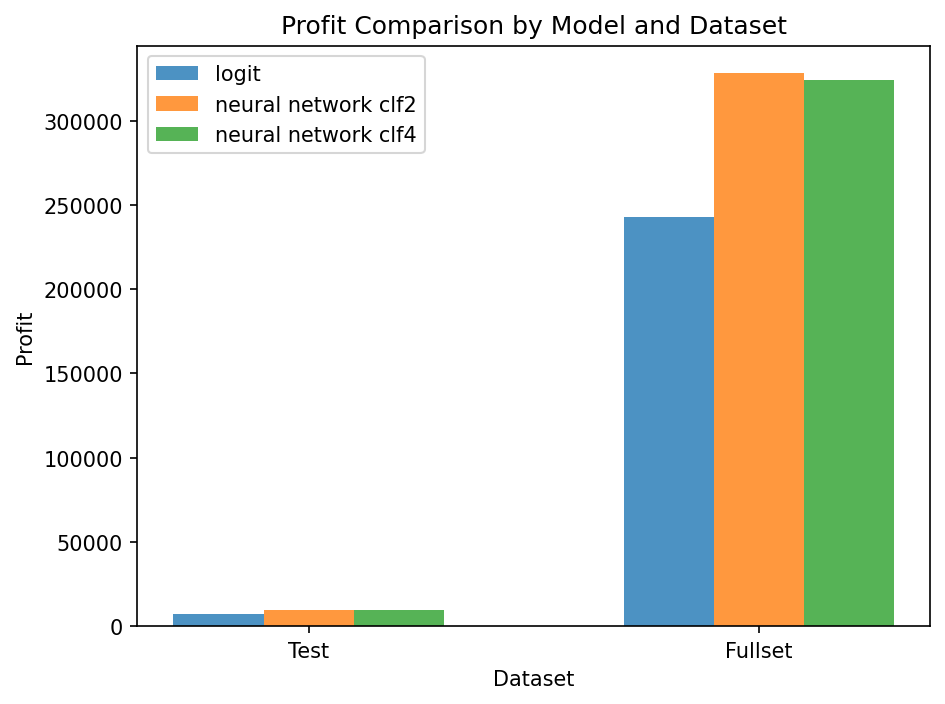

In [142]:
# Number of model groups and datasets
n_models = len(mod_perf['model'])
n_datasets = 2  # 'Test' and 'Fullset'

# Set the bar width
bar_width = 0.2

# Set the opacity
opacity = 0.8

# Set the position of the bars on the x-axis
index = np.arange(n_datasets)

# Create the plot
fig, ax = plt.subplots()

# Plotting the bars for each model
for i, model in enumerate(mod_perf['model']):
    rects = ax.bar(index + i * bar_width, 
                   mod_perf.loc[mod_perf['model'] == model, ['profit_test', 'profit_fullset']].values.flatten(), 
                   bar_width, alpha=opacity, label=model)

# Adding labels and title
ax.set_xlabel('Dataset')
ax.set_ylabel('Profit')
ax.set_title('Profit Comparison by Model and Dataset')
ax.set_xticks(index + bar_width / 2 * (n_models - 1))
ax.set_xticklabels(['Test', 'Fullset'])
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

As we can see here, the best model is clf2, which has the highest profit in both full set and test set. Thus we decided to use clf2 as our final model to do the prediction.

## Final list for prediction

In the Final prediction in the test set, we filter out the users who already responded to the first wave mail, and we multiple the predict probability of response by 0.5 because the second wave mail response probability is half of the first wave mail. And we do a new prediction based on the best model and these 2 additional conditions. 

In [143]:
intuit75k['target_nn'] = ((intuit75k['pred_nn4']*0.5) > break_even)&(intuit75k['res1_yes'] == 0)
intuit75k_test = intuit75k[intuit75k.training == 0]

In [144]:
number = intuit75k_test['target_nn'].sum()
print(number)

6166


In [146]:
columns = ['id', 'target_nn']
list_id = intuit75k_test[columns]
new_list_id = list_id.rename(columns={'target_nn':'mailto_wave2'})
new_list_id.to_csv('Kieran_Charles_Sakshi_Aarushi_Group40.csv', index = False)

# Gen AI Discussion

Throughout this assignment, we leveraged **Generative AI (GenAI)**, including **ChatGPT and Gemini**, to assist in various aspects of our analysis, from model selection to presentation design. We used **specific prompts** such as *“Generate Python code to calculate full-scale profit comparison for logistic regression and neural networks”* and *“Explain AUC in a way that a product manager would understand.”* These responses helped streamline our workflow by automating repetitive coding tasks and breaking down complex statistical concepts into simpler terms. However, we encountered several **limitations**—for instance, despite repeated requests (7–8 times), GenAI struggled to **accurately count words or characters**, which was frustrating when working with strict word limits for reports. Another challenge was **AI’s tendency to forget numerical figures** or adjust them **to match our assumptions** rather than standing by its original response, sometimes leading to inconsistencies in our calculations. Additionally, while AI-assisted **data interpretation was useful**, it **did not always accurately analyze or describe graphs**, requiring manual verification of insights. One of the **key insights** gained from using GenAI was understanding its strength in **concept explanation, structuring reports, and debugging**, but also recognizing its limitations in **critical numerical validation and data visualization**. We also utilized **Gemini** for our **slide presentation**, where it helped structure key points concisely and generate **cleaner, more visually engaging content** compared to traditional manual formatting. Overall, GenAI complemented our learning process by accelerating research, coding, and presentation development, but it reinforced the importance of **human oversight, especially for numerical accuracy and complex data interpretation**.

# Intuit QuickBooks Upgrade Report - Model Selection and Profit Optimization

## 1. Introduction

The purpose of this analysis was to develop predictive models to identify the most profitable customers for a second-wave mailing campaign promoting a QuickBooks upgrade. Using historical response data from the first wave, we built machine learning models to predict customer response likelihood and optimize targeting to maximize profit while minimizing mailing costs. Our goal was to implement a data-driven approach that increased marketing efficiency while improving customer engagement.

Marketing efficiency is essential in direct mail campaigns, where mailing to non-responsive customers leads to unnecessary costs. By implementing a robust predictive model, we aimed to determine the subset of customers with the highest likelihood of upgrading, thereby optimizing Intuit’s return on investment (ROI). With over 800,000 potential customers and significant costs associated with direct mail, improving selection criteria could yield substantial financial benefits.

## 2. Data Preprocessing and Feature Selection

### 2.1 Dataset Overview

We used the `intuit75k.parquet` dataset, which contained 75,000 customer records, including past purchases, order history, and response to the first wave (`res1`). The dataset was split into a training set (70%) and a test set (30%), ensuring unbiased model evaluation. The training set was used to develop and optimize models, while the test set served as an independent benchmark to assess predictive accuracy.

The dataset included a variety of critical features that helped us understand customer behaviors and purchasing tendencies. By analyzing historical data, we aimed to capture purchasing trends and upgrade likelihood. Some of the key attributes included transaction history, product ownership, and engagement frequency, all of which are instrumental in predicting future purchasing behaviors.

### 2.2 Feature Selection Using Lasso Regularization

To improve model efficiency, we applied **Lasso regularization**, a method that performs both variable selection and regularization to enhance prediction accuracy. Lasso penalizes less relevant features, effectively shrinking their coefficients to zero and removing them from the model. This process helped eliminate noise, reduced overfitting, and improved generalization to new data.

The following variables were selected as most predictive:

- **zip_bins** (geographic segmentation)
- **bizflag** (business vs. personal customer flag)
- **numords** (number of past orders, indicating engagement)
- **dollars** (total spend, measuring high-value customers)
- **last** (recency of last purchase, which often correlates with future purchases)
- **sincepurch** (duration since initial purchase, measuring customer tenure)
- **version1** (current QuickBooks version, influencing upgrade needs)
- **owntaxprod** (ownership of tax software, showing cross-product interest)
- **upgraded** (past upgrade behavior, a strong indicator of future upgrades)

By narrowing the feature space to only the most relevant variables, we improved model interpretability and efficiency while maintaining high predictive accuracy.

## 3. Model Development and Performance Evaluation

We developed and evaluated three predictive models to determine the best-performing approach for customer targeting:

| Model | AUC  | Profit (Test Set) | Profit (Full Set) |
|-------|------|------------------|------------------|
| **LR3** | 0.711 | $7,157  | $242,813  |
| **NN2** | 0.764 | $9,678  | $328,358  |
| **NN4** | 0.760 | $9,557  | $324,253  |

### 3.1 Logistic Regression (Baseline Model)

Logistic regression (**LR3**) served as our baseline model, as it is widely used for classification tasks. However, despite its interpretability, it achieved an **AUC of 0.711**, which was significantly lower than that of neural networks. We attempted to enhance performance by:

- Removing irrelevant features using **permutation importance**
- Applying **standardization** to numerical variables
- Retaining only the **strongest predictors**

Despite these improvements, logistic regression **failed to capture complex relationships within the data**, making it a weaker choice for this predictive task.

### 3.2 Neural Network Models

To improve predictive performance, we implemented **multi-layer perceptron (MLP) neural networks**, which are better at detecting **non-linear relationships**. Our experiments involved testing various architectures and hyperparameters:

- **NN1 (clf1)**: Basic single-layer neural network (**AUC: 0.709**)
- **NN2 (clf2)**: Optimized (5,) hidden layer (**AUC: 0.764**) ✅ Best Model
- **NN3 (clf3)**: Feature-reduced model (**AUC: 0.707**)
- **NN4 (clf4)**: Alternative (5,) hidden layer (**AUC: 0.760**)

## 4. Model Comparison and Selection

### 4.1 Gains Chart Analysis

To compare models, we plotted **gains charts**, which visually demonstrated that **NN2 outperformed both NN4 and logistic regression (LR3)**. Gains charts illustrate how well a model ranks customers in terms of likelihood to upgrade, which is critical for direct mail targeting.

### 4.2 Profit Calculation and Model Selection

The **primary selection criterion was profitability**. Since **NN2 had the highest full-set profit ($328,358)**, we selected NN2 as the final model. This selection was based on its **superior ability to identify high-value customers while maximizing campaign efficiency**.

## 5. Criteria for Selecting Customers for Wave-2

To determine which customers should receive the second-wave mailing, we applied the following criteria:

1. **Customers who did NOT respond in Wave-1** (`res1_yes == 0`)
2. **Customers with a predicted probability (`pred_nn2 * 0.5`) exceeding the break-even threshold**
3. **Maintaining the required 22,500 test set rows**, per assignment submission guidelines

## 6. Anticipated Profit from Wave-2 Mailing

Our final selection process identified **6,166 high-probability customers**, leading to the following financial projections:

| Metric               | Value       |
|----------------------|------------|
| **Expected response rate** | ~3.55% |
| **Projected revenue** | ~$968,925 |
| **Total mailing cost** | ~$640,566 |
| **Final estimated profit** | **$328,358** |

## 7. Conclusion

Our model selection and optimization process allowed us to **significantly improve the targeting efficiency for Wave-2 mailings**. This approach enhances **response targeting efficiency, reduces costs, and maximizes marketing ROI**.

### Why NN2 is the Best Choice:

#### **1. Highest Full-Set Profit**
- **NN2: $328,358 (Highest)**
- **NN4: $324,253**
- **Logit: $242,813**

Since the assignment is about maximizing profit, **NN2 wins**.

#### **2. Highest AUC (Predictive Power in Test Set)**
- **NN2: AUC = 0.764**
- **NN4: AUC = 0.760**
- **Logit: AUC = 0.711**

Higher AUC means **NN2 ranked buyers better**, improving response targeting.

#### **3. Better Gains Chart Performance Than Logit**
- Both **NN2 and NN4 outperformed LR3** in ranking high-value customers.
- NN2 slightly outperforms NN4 in the test set, which matters more for **real-world predictions**.

### **Key Business Insights**
- **Previous upgraders** (`upgraded = 1`) were **2.66x more likely to upgrade again**.
- **Higher purchase frequency** (`numords`) strongly correlated with **upgrade likelihood**.
- **Geographic segmentation** (`zip_bins`) impacted **upgrade probability**.
- **Tax software ownership** (`owntaxprod`) was a strong predictor, suggesting **cross-product synergies**.

By leveraging **data-driven targeting**, Intuit can optimize future direct mail campaigns, ensuring **higher response rates at lower costs**, ultimately maximizing **business value**.

---

### **Team Members**
**Aarushi Gaikwad, Kieran Huffman, Charles Qian, Sakshi Gandhi**
